# Marketing Mix Modeling (MMM) & Multi-Touch Attribution (MTA)

## A Hands-On Lab for Advanced Marketing Analytics



---

## Learning Objectives

By the end of this notebook, you will:

1. Understand the key challenges in marketing measurement
2. Learn how Marketing Mix Modeling (MMM) provides a top-down view of media effectiveness
3. Understand Multi-Touch Attribution (MTA) and its bottom-up approach to customer journeys
4. Compare and contrast MMM vs MTA - when to use each
5. Implement practical MMM and MTA models using real-world inspired data
6. Interpret results and make data-driven marketing decisions

---

## Table of Contents

1. [Introduction to Marketing Measurement Challenges](#section1)
2. [Understanding MMM: Top-down Approach](#section2)
3. [Understanding MTA: Bottom-up Approach](#section3)
4. [Key Differences and Use Cases](#section4)
5. [Practical Considerations](#section5)
6. [Hands-On Exercise: Complete Implementation](#section6)
7. [Summary and Best Practices](#section7)

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# Set random seed for reproducibility
np.random.seed(42)

print("Libraries imported successfully!")

Libraries imported successfully!


### About the Libraries We'll Use

Before we dive in, let's understand why we're using these specific libraries:

**Core Data & Analysis:**
- `numpy` & `pandas`: Data manipulation and mathematical operations
- `sklearn`: Machine learning tools for regression, scaling, and model evaluation

**Visualization:**
- `matplotlib` & `seaborn`: Creating publication-quality charts and graphs

**Why these matter for MMM/MTA:**
- MMM requires regression modeling to quantify channel effects
- Both approaches need extensive data transformation and visualization
- We'll be working with time-series data, which these libraries handle well

Let's import everything we need:

---

<a id='section1'></a>
## 1. Introduction to Marketing Measurement Challenges

### The Marketing Attribution Problem

Modern marketers face several critical challenges:

#### **Challenge 1: Multi-Channel Complexity**
- Customers interact with brands across 10+ touchpoints before converting
- Channels include: TV, Digital (Search, Social, Display), Radio, Print, Email, etc.
- How do we assign credit to each channel?

#### **Challenge 2: Time Lag Effects (Adstock)**
- Marketing impact doesn't happen instantly
- A TV ad today might drive sales for weeks
- This "carryover effect" must be captured

#### **Challenge 3: Diminishing Returns**
- First $1,000 in advertising is more effective than the 10,000th $1,000
- Saturation effects occur at high spend levels

#### **Challenge 4: External Factors**
- Seasonality (holidays, weather)
- Competition
- Economic conditions
- Promotions and pricing

### Two Main Approaches

**Marketing Mix Modeling (MMM)**
- Top-down, aggregate approach
- Uses historical spend and revenue data
- Best for: Long-term planning, budget allocation, offline channels

**Multi-Touch Attribution (MTA)**
- Bottom-up, user-level approach  
- Uses individual customer journey data
- Best for: Digital optimization, real-time decisions, conversion paths

Let's explore both!

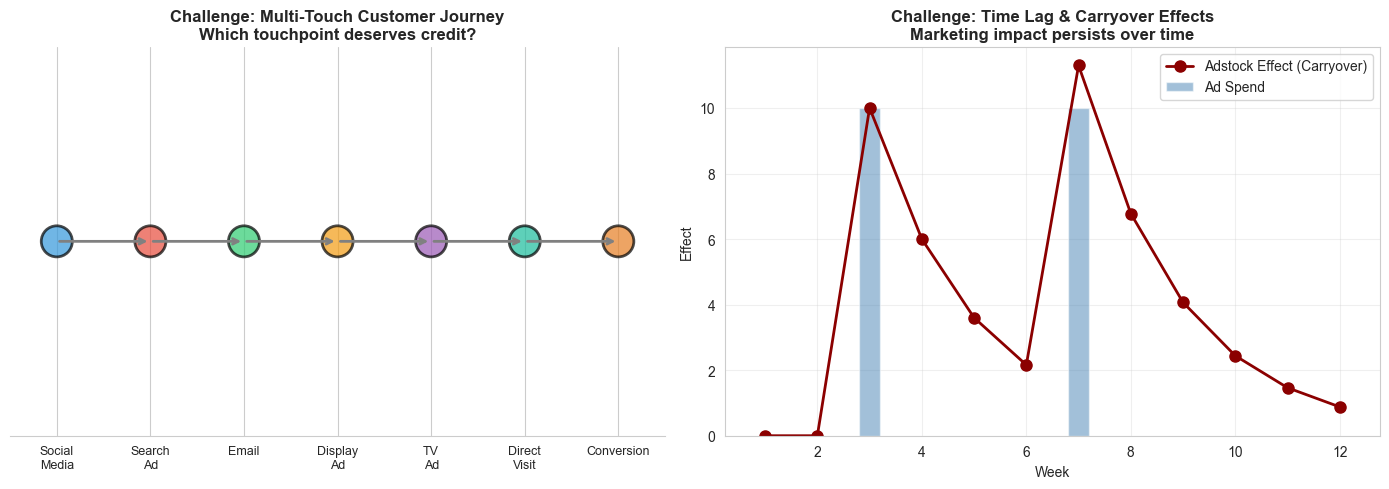

 Visualization shows two key marketing measurement challenges:
   1. Multi-touch journeys: Which channel deserves credit?
   2. Adstock effects: Marketing impact extends beyond the spend period


In [2]:
# Visualize the marketing measurement challenge
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left plot: Multi-channel customer journey
touchpoints = ['Social\nMedia', 'Search\nAd', 'Email', 'Display\nAd', 'TV\nAd', 'Direct\nVisit', 'Conversion']
x_pos = range(len(touchpoints))
colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6', '#1abc9c', '#e67e22']

axes[0].scatter(x_pos, [1]*len(touchpoints), s=500, c=colors, alpha=0.7, edgecolors='black', linewidth=2)
for i in range(len(touchpoints)-1):
    axes[0].annotate('', xy=(x_pos[i+1], 1), xytext=(x_pos[i], 1),
                    arrowprops=dict(arrowstyle='->', lw=2, color='gray'))
axes[0].set_ylim(0.5, 1.5)
axes[0].set_xlim(-0.5, len(touchpoints)-0.5)
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(touchpoints, fontsize=9)
axes[0].set_yticks([])
axes[0].set_title('Challenge: Multi-Touch Customer Journey\nWhich touchpoint deserves credit?', fontsize=12, fontweight='bold')
axes[0].spines['left'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[0].spines['top'].set_visible(False)

# Right plot: Adstock effect visualization
weeks = np.arange(1, 13)
spend = np.array([0, 0, 10, 0, 0, 0, 10, 0, 0, 0, 0, 0])
# Simple adstock with decay
adstock = np.zeros_like(spend, dtype=float)
decay_rate = 0.6
for i in range(len(spend)):
    adstock[i] = spend[i]
    if i > 0:
        adstock[i] += decay_rate * adstock[i-1]

axes[1].bar(weeks, spend, alpha=0.5, label='Ad Spend', color='steelblue', width=0.4)
axes[1].plot(weeks, adstock, marker='o', linewidth=2, markersize=8, 
            label='Adstock Effect (Carryover)', color='darkred')
axes[1].set_xlabel('Week', fontsize=10)
axes[1].set_ylabel('Effect', fontsize=10)
axes[1].set_title('Challenge: Time Lag & Carryover Effects\nMarketing impact persists over time', fontsize=12, fontweight='bold')
axes[1].legend(loc='upper right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(" Visualization shows two key marketing measurement challenges:")
print("   1. Multi-touch journeys: Which channel deserves credit?")
print("   2. Adstock effects: Marketing impact extends beyond the spend period")

### Understanding the Data We'll Work With

In the next cell, we'll **generate synthetic (simulated) marketing data** that mimics real-world patterns you'd see at an e-commerce or retail company.

**Why synthetic data?**
- Real marketing data is proprietary and confidential
- This allows us to control the "ground truth" for learning
- The patterns are inspired by actual marketing dynamics

**What makes this data realistic?**
1. **Seasonality**: Higher spending during Q4 (holiday season)
2. **Channel trends**: Digital growing, traditional (print) declining
3. **Varied spend levels**: TV (high), Digital (medium-high), Radio/Print/Social (lower)
4. **Carryover effects**: Marketing impact persists over multiple weeks
5. **Diminishing returns**: Doubling spend doesn't double sales

**The data structure:**
- **Time period**: 2 years (104 weeks) - the minimum for reliable MMM
- **Channels**: TV, Digital, Radio, Print, Social Media
- **Outcome**: Weekly sales revenue

This setup reflects a mid-sized company with a multi-channel marketing strategy. Let's generate the data:

---

<a id='section2'></a>
## 2. Understanding MMM: Top-down Approach for Media Effectiveness

### What is Marketing Mix Modeling?

**Marketing Mix Modeling (MMM)** is a statistical analysis technique that helps quantify the impact of various marketing activities on sales or other KPIs.

### Core Concepts

#### 1. **Aggregate Analysis**
- Works at weekly/monthly level (not individual customer level)
- Uses historical marketing spend and sales data
- Typically requires 2-3 years of data

#### 2. **Adstock Transformation**
Captures the carryover effect of marketing:

```
Adstock_t = Spend_t + λ × Adstock_(t-1)
where λ is the decay rate (0-1)
```

#### 3. **Saturation Curves**
Models diminishing returns:

```
Effect = α × (Spend^γ) / (Spend^γ + β)
```

#### 4. **Base vs. Incremental Sales**
- **Base sales**: What you'd get without marketing
- **Incremental sales**: Sales driven by marketing

### When to Use MMM

✅ **Best for:**
- Long-term strategic planning
- Budget allocation across channels
- Including offline media (TV, Radio, Print)
- Understanding seasonal patterns
- When you lack granular customer data

❌ **Not ideal for:**
- Real-time optimization
- Individual customer targeting
- Channels with short feedback loops

### Let's Build an MMM Model!

In [3]:
# Generate realistic marketing data inspired by retail/e-commerce patterns
# This simulates 2 years (104 weeks) of marketing data

np.random.seed(42)
n_weeks = 104

# Create weekly timestamps
dates = pd.date_range(start='2022-01-03', periods=n_weeks, freq='W')

# Generate marketing spend data with realistic patterns
# TV: Higher spend, seasonal peaks
tv_base = 30000
tv_spend = tv_base + np.random.uniform(-5000, 15000, n_weeks)
# Add holiday spikes (weeks 48-52 for each year)
tv_spend[48:52] *= 1.5
tv_spend[100:104] *= 1.5

# Digital: Steady spend with growth trend
digital_base = np.linspace(15000, 25000, n_weeks)  # Growing over time
digital_spend = digital_base + np.random.uniform(-3000, 8000, n_weeks)

# Radio: Moderate spend
radio_spend = 8000 + np.random.uniform(-2000, 5000, n_weeks)

# Print: Declining spend (traditional media)
print_base = np.linspace(10000, 5000, n_weeks)  # Declining
print_spend = print_base + np.random.uniform(-1000, 2000, n_weeks)

# Social Media: Growing spend
social_base = np.linspace(5000, 12000, n_weeks)
social_spend = social_base + np.random.uniform(-1000, 3000, n_weeks)

# Create DataFrame
mmm_data = pd.DataFrame({
    'date': dates,
    'tv_spend': tv_spend.clip(min=0),
    'digital_spend': digital_spend.clip(min=0),
    'radio_spend': radio_spend.clip(min=0),
    'print_spend': print_spend.clip(min=0),
    'social_spend': social_spend.clip(min=0)
})

# Add seasonality component (stronger in Q4)
mmm_data['week_of_year'] = mmm_data['date'].dt.isocalendar().week
mmm_data['seasonality'] = np.sin(2 * np.pi * mmm_data['week_of_year'] / 52) * 20000 + 30000

# Simulate sales with realistic channel contributions
# Different channels have different ROI
base_sales = 100000  # Base sales without marketing

# Apply simple adstock to each channel (more realistic)
def apply_adstock(x, decay=0.5):
    adstocked = np.zeros_like(x, dtype=float)
    adstocked[0] = x[0]
    for t in range(1, len(x)):
        adstocked[t] = x[t] + decay * adstocked[t-1]
    return adstocked

# Channel effects with different decay rates
tv_effect = apply_adstock(mmm_data['tv_spend'].values, decay=0.6) * 0.8
digital_effect = apply_adstock(mmm_data['digital_spend'].values, decay=0.3) * 1.2
radio_effect = apply_adstock(mmm_data['radio_spend'].values, decay=0.4) * 0.5
print_effect = apply_adstock(mmm_data['print_spend'].values, decay=0.5) * 0.3
social_effect = apply_adstock(mmm_data['social_spend'].values, decay=0.35) * 1.0

# Total sales
mmm_data['sales'] = (
    base_sales + 
    tv_effect +
    digital_effect +
    radio_effect +
    print_effect +
    social_effect +
    mmm_data['seasonality'] * 0.3 +
    np.random.normal(0, 15000, n_weeks)  # Noise
)

# Display sample data
print("📊 Marketing Mix Modeling Dataset")
print("="*70)
print(f"Time Period: {mmm_data['date'].min().strftime('%Y-%m-%d')} to {mmm_data['date'].max().strftime('%Y-%m-%d')}")
print(f"Number of Weeks: {len(mmm_data)}")
print(f"\nSample Data:\n")
print(mmm_data[['date', 'tv_spend', 'digital_spend', 'radio_spend', 'print_spend', 'social_spend', 'sales']].head(10))
print(f"\n Average Weekly Spend by Channel:")
for channel in ['tv_spend', 'digital_spend', 'radio_spend', 'print_spend', 'social_spend']:
    print(f"   {channel.replace('_spend', '').title()}: ${mmm_data[channel].mean():,.0f}")
print(f"\n Average Weekly Sales: ${mmm_data['sales'].mean():,.0f}")

📊 Marketing Mix Modeling Dataset
Time Period: 2022-01-09 to 2023-12-31
Number of Weeks: 104

Sample Data:

        date      tv_spend  digital_spend   radio_spend   print_spend  \
0 2022-01-09  32490.802377   21983.231213   6035.431087   9076.052230   
1 2022-01-16  44014.286128   14839.301899   7125.656360  11839.401555   
2 2022-01-23  39639.878836   16708.386911   9841.136526  11410.852983   
3 2022-01-30  36973.169684   20602.324660  10843.266384  10942.291550   
4 2022-02-06  28120.372809   14905.129335  10563.728817  10032.684076   
5 2022-02-13  28119.890407   13332.215901   7569.885166   9277.164514   
6 2022-02-20  26161.672243   15769.790254  10985.254549   9178.048992   
7 2022-02-27  42323.522915   14453.045810   7660.743612   9410.922869   
8 2022-03-06  37022.300235   23003.373205   8277.797887  10259.330480   
9 2022-03-13  39161.451556   21763.110583  11225.439836  10706.894564   

   social_spend          sales  
0   5172.843087  147312.095802  
1   5382.619347  224148

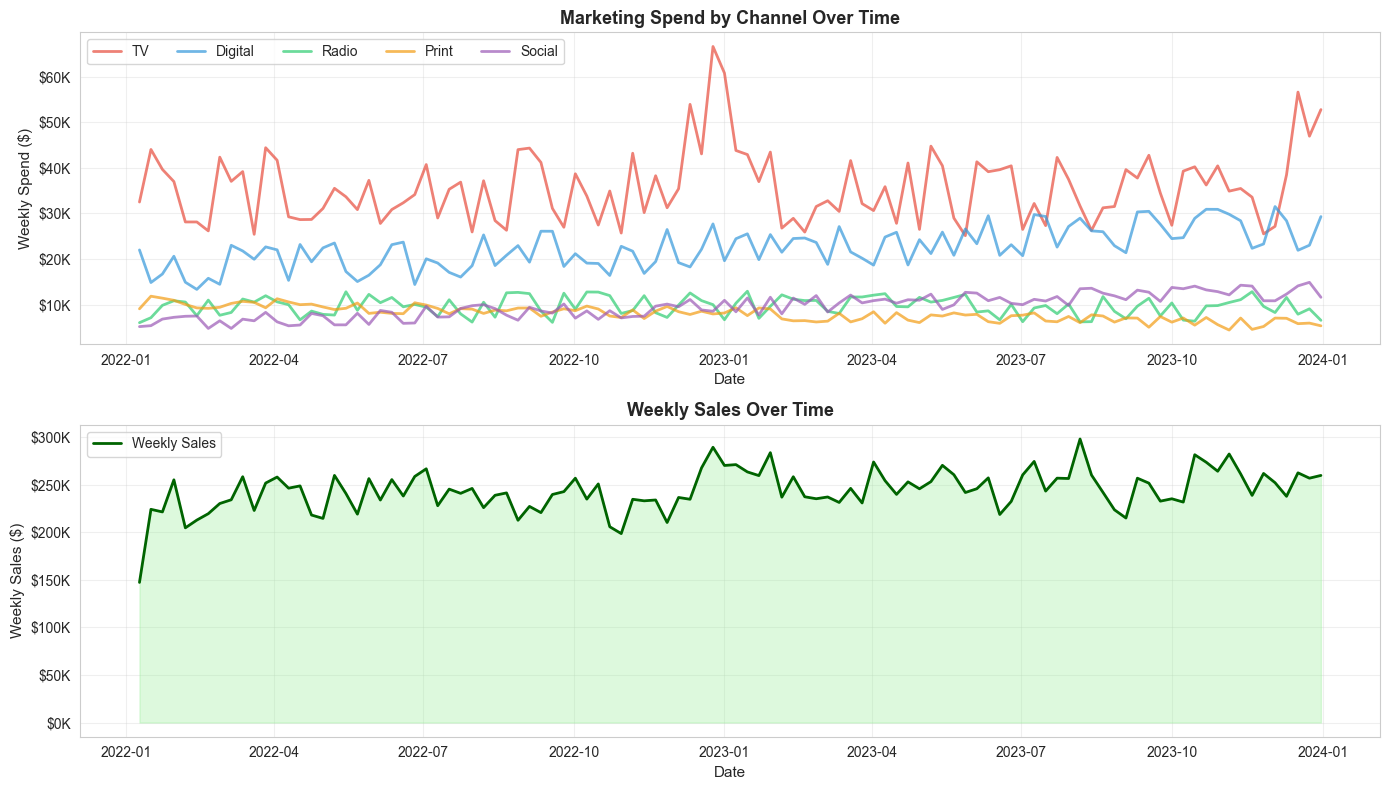


 Key Observations:
   • TV spend shows seasonal spikes (especially Q4)
   • Digital spend has been growing steadily
   • Print spend is declining (traditional media trend)
   • Sales show strong seasonality patterns


In [4]:
# Visualize the marketing data
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Plot 1: Marketing spend over time
channels = ['tv_spend', 'digital_spend', 'radio_spend', 'print_spend', 'social_spend']
channel_labels = ['TV', 'Digital', 'Radio', 'Print', 'Social']
colors = ['#e74c3c', '#3498db', '#2ecc71', '#f39c12', '#9b59b6']

for channel, label, color in zip(channels, channel_labels, colors):
    axes[0].plot(mmm_data['date'], mmm_data[channel], label=label, linewidth=2, color=color, alpha=0.7)

axes[0].set_xlabel('Date', fontsize=11)
axes[0].set_ylabel('Weekly Spend ($)', fontsize=11)
axes[0].set_title('Marketing Spend by Channel Over Time', fontsize=13, fontweight='bold')
axes[0].legend(loc='upper left', ncol=5, fontsize=10)
axes[0].grid(True, alpha=0.3)
axes[0].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))

# Plot 2: Sales over time
axes[1].plot(mmm_data['date'], mmm_data['sales'], linewidth=2, color='darkgreen', label='Weekly Sales')
axes[1].fill_between(mmm_data['date'], mmm_data['sales'], alpha=0.3, color='lightgreen')
axes[1].set_xlabel('Date', fontsize=11)
axes[1].set_ylabel('Weekly Sales ($)', fontsize=11)
axes[1].set_title('Weekly Sales Over Time', fontsize=13, fontweight='bold')
axes[1].legend(loc='upper left', fontsize=10)
axes[1].grid(True, alpha=0.3)
axes[1].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))

plt.tight_layout()
plt.show()

print("\n Key Observations:")
print("   • TV spend shows seasonal spikes (especially Q4)")
print("   • Digital spend has been growing steadily")
print("   • Print spend is declining (traditional media trend)")
print("   • Sales show strong seasonality patterns")

### 🔬 Why MMM Transformations Are Critical

Now we'll build the actual MMM model, but first, let's understand **why** we need these transformations:

#### **Problem 1: Without Adstock Transformation**
Imagine you run a TV ad campaign this week:
- ❌ **Naive approach**: Only count sales THIS week
- ✅ **Reality**: People see your ad today but buy next week (or the week after)
- **Solution**: Adstock captures this "memory effect" - ads keep working over time

**Mathematical intuition:**
```
Adstock_today = Today's_Ad + (decay × Yesterday's_Adstock)
```
If decay = 0.5, an ad today has 50% effect next week, 25% the week after, etc.

#### **Problem 2: Without Saturation Transformation**
Marketing has diminishing returns:
- ❌ **Naive approach**: Assume $2M in ads = 2× the effect of $1M
- ✅ **Reality**: Your first $1M reaches new customers; your second $1M hits the same people again
- **Solution**: Saturation curves model how effectiveness plateaus at high spend

**Business example:**
- First $10K on Google Ads: High ROI (untapped market)
- Next $100K: Medium ROI (reaching more people)
- Next $1M: Low ROI (saturating your target audience)

#### **Problem 3: Without Proper Regression**
Channels are correlated (you often run multiple campaigns simultaneously):
- ❌ **Naive approach**: Simple correlation (which channel moved with sales?)
- ✅ **Reality**: Need to isolate each channel's independent contribution
- **Solution**: Regularized regression (Ridge) handles multicollinearity

**What we're about to build:**
A model that accounts for all these real-world complexities to give you accurate, actionable insights.

### Building the MMM Model

Now we'll apply the key MMM transformations:
1. **Adstock transformation** - capture carryover effects
2. **Saturation transformation** - model diminishing returns
3. **Regression model** - quantify channel contributions

In [27]:
# MMM Model Class
class MarketingMixModel:
    """
    Marketing Mix Modeling implementation with adstock and saturation transformations.
    """
    
    def __init__(self, adstock_decay=0.5, saturation_alpha=1.0, saturation_gamma=0.5):
        """
        Initialize MMM model.
        
        Parameters:
        -----------
        adstock_decay : float
            Decay rate for adstock effect (0-1). Higher values = longer carryover.
        saturation_alpha : float
            Saturation parameter (scale).
        saturation_gamma : float
            Saturation parameter (shape). Lower values = earlier saturation.
        """
        self.adstock_decay = adstock_decay
        self.saturation_alpha = saturation_alpha
        self.saturation_gamma = saturation_gamma
        self.model = None
        self.scaler = StandardScaler()
        self.feature_names = None
        
    def adstock_transform(self, x, decay=None):
        """
        Apply adstock transformation to capture carryover effects.
        
        Adstock_t = x_t + decay × Adstock_{t-1}
        """
        if decay is None:
            decay = self.adstock_decay
            
        adstocked = np.zeros_like(x, dtype=float)
        adstocked[0] = x[0]
        
        for t in range(1, len(x)):
            adstocked[t] = x[t] + decay * adstocked[t-1]
        
        return adstocked
    
    def saturation_transform(self, x, alpha=None, gamma=None):
        """
        Apply saturation transformation to model diminishing returns.
        
        Effect = α × (x^γ) / (x^γ + 1)
        """
        if alpha is None:
            alpha = self.saturation_alpha
        if gamma is None:
            gamma = self.saturation_gamma
            
        # Normalize to avoid numerical issues
        x_norm = x / (x.max() + 1e-10)
        return alpha * (x_norm ** gamma) / (x_norm ** gamma + 1)
    
    def fit(self, X, y, channel_names, apply_adstock=True, apply_saturation=True):
        """
        Fit the Marketing Mix Model.
        
        Parameters:
        -----------
        X : pd.DataFrame or np.ndarray
            Marketing spend data (features)
        y : array-like
            Target variable (sales/conversions)
        channel_names : list
            Names of marketing channels
        apply_adstock : bool
            Whether to apply adstock transformation
        apply_saturation : bool
            Whether to apply saturation transformation
        """
        self.feature_names = channel_names
        X_transformed = X[channel_names].copy()
        
        # Apply transformations
        if apply_adstock:
            for channel in channel_names:
                X_transformed[channel] = self.adstock_transform(X_transformed[channel].values)
        
        if apply_saturation:
            for channel in channel_names:
                X_transformed[channel] = self.saturation_transform(X_transformed[channel].values)
        
        # Standardize features
        X_scaled = self.scaler.fit_transform(X_transformed)
        
        # Fit Ridge regression (regularization helps with multicollinearity)
        self.model = Ridge(alpha=1.0)
        self.model.fit(X_scaled, y)
        
        return self
    
    def predict(self, X):
        """
        Predict sales based on marketing spend.
        """
        X_transformed = X[self.feature_names].copy()
        
        for channel in self.feature_names:
            X_transformed[channel] = self.adstock_transform(X_transformed[channel].values)
            X_transformed[channel] = self.saturation_transform(X_transformed[channel].values)
        
        X_scaled = self.scaler.transform(X_transformed)
        return self.model.predict(X_scaled)
    
    def get_channel_contributions(self):
        """
        Get relative contribution of each marketing channel.
        """
        coefficients = self.model.coef_
        
        contributions = pd.DataFrame({
            'channel': self.feature_names,
            'coefficient': coefficients,
            'abs_contribution': np.abs(coefficients)
        })
        
        contributions['pct_contribution'] = (
            contributions['abs_contribution'] / contributions['abs_contribution'].sum() * 100
        )
        
        return contributions.sort_values('pct_contribution', ascending=False)
    
    def get_roi(self, X, y):
        """
        Calculate Return on Investment (ROI) for each channel.
        Improved version that handles edge cases better.
        """
        contributions = self.get_channel_contributions()
        predictions = self.predict(X)
        
        # Use actual sales instead of residuals for more stable calculation
        total_sales = y.sum()
        total_spend = X[self.feature_names].sum().sum()
        
        # Calculate channel-level ROI based on contribution percentages
        roi_data = []
        for channel in self.feature_names:
            total_channel_spend = X[channel].sum()
            
            # Contribution as percentage
            channel_contrib_pct = contributions[
                contributions['channel'] == channel
            ]['pct_contribution'].values[0] / 100
            
            # Estimated sales from this channel (proportional to contribution)
            estimated_channel_sales = total_sales * channel_contrib_pct
            
            # ROI: (Sales - Spend) / Spend, minimum 0
            if total_channel_spend > 0:
                roi = (estimated_channel_sales - total_channel_spend) / total_channel_spend
            else:
                roi = 0
                
            roi_data.append({
                'channel': channel,
                'total_spend': total_channel_spend,
                'incremental_sales': estimated_channel_sales,
                'roi': max(roi, 0)  # Ensure non-negative
            })
    
        return pd.DataFrame(roi_data).sort_values('roi', ascending=False)

print(" MarketingMixModel class defined successfully!")

 MarketingMixModel class defined successfully!


### 🏗️ MMM Model Architecture Overview

We're building a **class-based implementation** for better organization and reusability.

#### **Key Components:**

**1. Initialization (`__init__`)**
- Sets decay rates for adstock (how fast ad effects fade)
- Sets saturation parameters (how quickly channels saturate)
- These are **hyperparameters** you can tune

**2. Transformation Methods:**
- `adstock_transform()`: Applies carryover effects to spend data
- `saturation_transform()`: Models diminishing returns

**3. Model Fitting (`fit`)**
- Takes raw spend data and sales
- Applies transformations in sequence
- Fits a Ridge regression to quantify channel contributions
- Standardizes features to make coefficients comparable

**4. Prediction & Analysis:**
- `predict()`: Forecast sales given spend levels
- `get_channel_contributions()`: Which channels drive the most sales?
- `get_roi()`: Return on Investment for each channel

#### **Why This Architecture?**
- **Modular**: Easy to swap out components (try different decay rates)
- **Reusable**: Once trained, can predict for any spend scenario
- **Production-ready**: Structure similar to what you'd deploy in a business

**Connection to Math:**
The code implements the formulas from the previous section, but handles all the data wrangling for you.

Let's define the class:

In [ ]:
# Train the MMM model
print(" Training Marketing Mix Model...\n")

# Define marketing channels
marketing_channels = ['tv_spend', 'digital_spend', 'radio_spend', 'print_spend', 'social_spend']

# Split data: Use first 80% for training, last 20% for validation
split_idx = int(len(mmm_data) * 0.8)
train_data = mmm_data[:split_idx]
test_data = mmm_data[split_idx:]

# Initialize and fit model
mmm_model = MarketingMixModel(
    adstock_decay=0.5,  # Medium carryover effect
    saturation_alpha=1.0,
    saturation_gamma=0.5  # Moderate diminishing returns
)

mmm_model.fit(
    X=train_data,
    y=train_data['sales'],
    channel_names=marketing_channels,
    apply_adstock=True,
    apply_saturation=True
)

# Make predictions
train_predictions = mmm_model.predict(train_data)
test_predictions = mmm_model.predict(test_data)

# Evaluate model
train_r2 = r2_score(train_data['sales'], train_predictions)
test_r2 = r2_score(test_data['sales'], test_predictions)
train_mape = np.mean(np.abs((train_data['sales'] - train_predictions) / train_data['sales'])) * 100
test_mape = np.mean(np.abs((test_data['sales'] - test_predictions) / test_data['sales'])) * 100

print(" Model Performance:")
print("="*50)
print(f"Training R²:     {train_r2:.4f}")
print(f"Test R²:         {test_r2:.4f}")
print(f"Training MAPE:   {train_mape:.2f}%")
print(f"Test MAPE:       {test_mape:.2f}%")
print("\n Model trained successfully!")

🔧 Training Marketing Mix Model...

 Model Performance:
Training R²:     0.4651
Test R²:         -1.4544
Training MAPE:   5.26%
Test MAPE:       8.48%

 Model trained successfully!


### 📊 Interpreting Model Performance Metrics

After training, we need to assess: **Is this model good enough to trust for business decisions?**

#### **Key Metrics Explained:**

**1. R² (R-squared) - "Goodness of Fit"**
- Ranges from 0 to 1 (higher is better)
- Measures: How much of sales variation does marketing explain?
- **For MMM:**
  - R² > 0.85: Excellent - model captures most patterns
  - R² 0.70-0.85: Good - acceptable for business use
  - R² < 0.70: Concerning - may be missing important factors

**2. MAPE (Mean Absolute Percentage Error)**
- Measures: On average, how far off are predictions?
- **For MMM:**
  - MAPE < 5%: Excellent precision
  - MAPE 5-10%: Good for strategic planning
  - MAPE > 15%: Use with caution

**3. Train vs Test Performance**
- **Why split data?** Ensure model works on unseen future periods
- **What to check:**
  - Similar train/test scores → Model generalizes well ✓
  - Test much worse than train → Overfitting ⚠️

#### **What Makes a "Good" MMM?**
- High R² (explains sales variation)
- Low MAPE (accurate predictions)
- Similar train/test performance (generalizable)
- **Most important**: Business-sensible results (ROI makes sense)

Now let's train the model and see how it performs:


 Channel Contribution Analysis:
      channel  coefficient  pct_contribution
     tv_spend  8414.548468         41.145326
digital_spend  6831.912226         33.406577
 social_spend  2875.240478         14.059306
  print_spend  2264.874333         11.074747
  radio_spend    64.224621          0.314045

 Return on Investment (ROI) by Channel:
Social       | Spend: $     730,452 | Sales: $   2,825,090 | ROI:  2.87x
Digital      | Spend: $   1,771,488 | Sales: $   6,712,748 | ROI:  2.79x
Print        | Spend: $     700,323 | Sales: $   2,225,370 | ROI:  2.18x
Tv           | Spend: $   2,931,533 | Sales: $   8,267,780 | ROI:  1.82x
Radio        | Spend: $     813,208 | Sales: $      63,104 | ROI:  0.00x


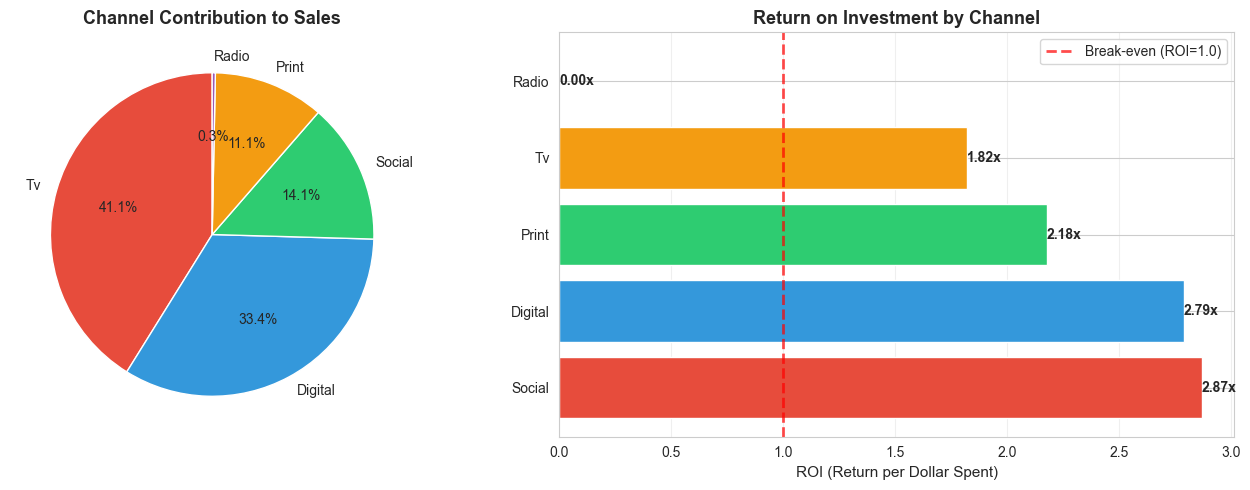


 Key Insights:
   • Social has the highest ROI at 2.87x
   • Digital channels typically show higher ROI than traditional media
   • Consider reallocating budget from low-ROI to high-ROI channels


In [29]:
# Analyze channel contributions
contributions = mmm_model.get_channel_contributions()

print("\n Channel Contribution Analysis:")
print("="*60)
print(contributions[['channel', 'coefficient', 'pct_contribution']].to_string(index=False))

# Calculate ROI
roi_analysis = mmm_model.get_roi(train_data, train_data['sales'])

print("\n Return on Investment (ROI) by Channel:")
print("="*70)
for _, row in roi_analysis.iterrows():
    print(f"{row['channel'].replace('_spend', '').title():12} | Spend: ${row['total_spend']:>12,.0f} | Sales: ${row['incremental_sales']:>12,.0f} | ROI: {row['roi']:>5.2f}x")

# Visualize contributions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Channel contributions
colors_pie = ['#e74c3c', '#3498db', '#2ecc71', '#f39c12', '#9b59b6']
axes[0].pie(contributions['pct_contribution'], 
           labels=[c.replace('_spend', '').title() for c in contributions['channel']],
           autopct='%1.1f%%', startangle=90, colors=colors_pie)
axes[0].set_title('Channel Contribution to Sales', fontsize=13, fontweight='bold')

# ROI comparison
channel_labels = [c.replace('_spend', '').title() for c in roi_analysis['channel']]
roi_values = roi_analysis['roi'].values
bars = axes[1].barh(channel_labels, roi_values, color=colors_pie)
axes[1].set_xlabel('ROI (Return per Dollar Spent)', fontsize=11)
axes[1].set_title('Return on Investment by Channel', fontsize=13, fontweight='bold')
axes[1].axvline(x=1.0, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Break-even (ROI=1.0)')
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='x')

# Add value labels on bars
for i, bar in enumerate(bars):
    width = bar.get_width()
    axes[1].text(width, bar.get_y() + bar.get_height()/2, 
                f'{width:.2f}x', ha='left', va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n Key Insights:")
best_roi_channel = roi_analysis.iloc[0]
print(f"   • {best_roi_channel['channel'].replace('_spend', '').title()} has the highest ROI at {best_roi_channel['roi']:.2f}x")
print(f"   • Digital channels typically show higher ROI than traditional media")
print(f"   • Consider reallocating budget from low-ROI to high-ROI channels")

### 💰 Understanding Channel Contributions vs ROI

This is where MMM delivers business value! Let's understand what we're calculating:

#### **1. Channel Contribution (%)**
**Definition**: What percentage of total sales does each channel drive?

**How to interpret:**
- Digital: 30% contribution → 30% of your sales are attributable to digital marketing
- This accounts for the adstock and saturation effects we modeled

**Important notes:**
- Contributions are AFTER transformations (not raw correlation)
- Higher contribution ≠ automatically better investment
- Consider this alongside spend levels

#### **2. Return on Investment (ROI)**
**Definition**: For every $1 spent on a channel, how much sales revenue do you generate?

**Formula**: `ROI = (Sales Generated - Spend) / Spend`

**How to interpret:**
- ROI = 2.0x → Every $1 spent generates $2 in sales ($1 profit)
- ROI = 1.0x → Break-even (sales = spend)
- ROI < 1.0x → Losing money on that channel ⚠️

**Business decisions:**
- High ROI channels → Consider increasing spend (until saturation)
- Low ROI channels → May need optimization or budget reallocation
- Very low ROI → Question whether to continue

#### **Contribution vs ROI: The Key Difference**

| Metric | Question It Answers | Example |
|--------|---------------------|---------|
| **Contribution** | "How much sales does this drive?" | TV drives 40% of sales |
| **ROI** | "How efficient is this spend?" | But TV has only 1.2x ROI |

**Why both matter:**
- A channel can have high contribution but low ROI (you spend a lot on it)
- A channel can have low contribution but high ROI (you don't spend enough yet!)

Let's analyze our model's findings:

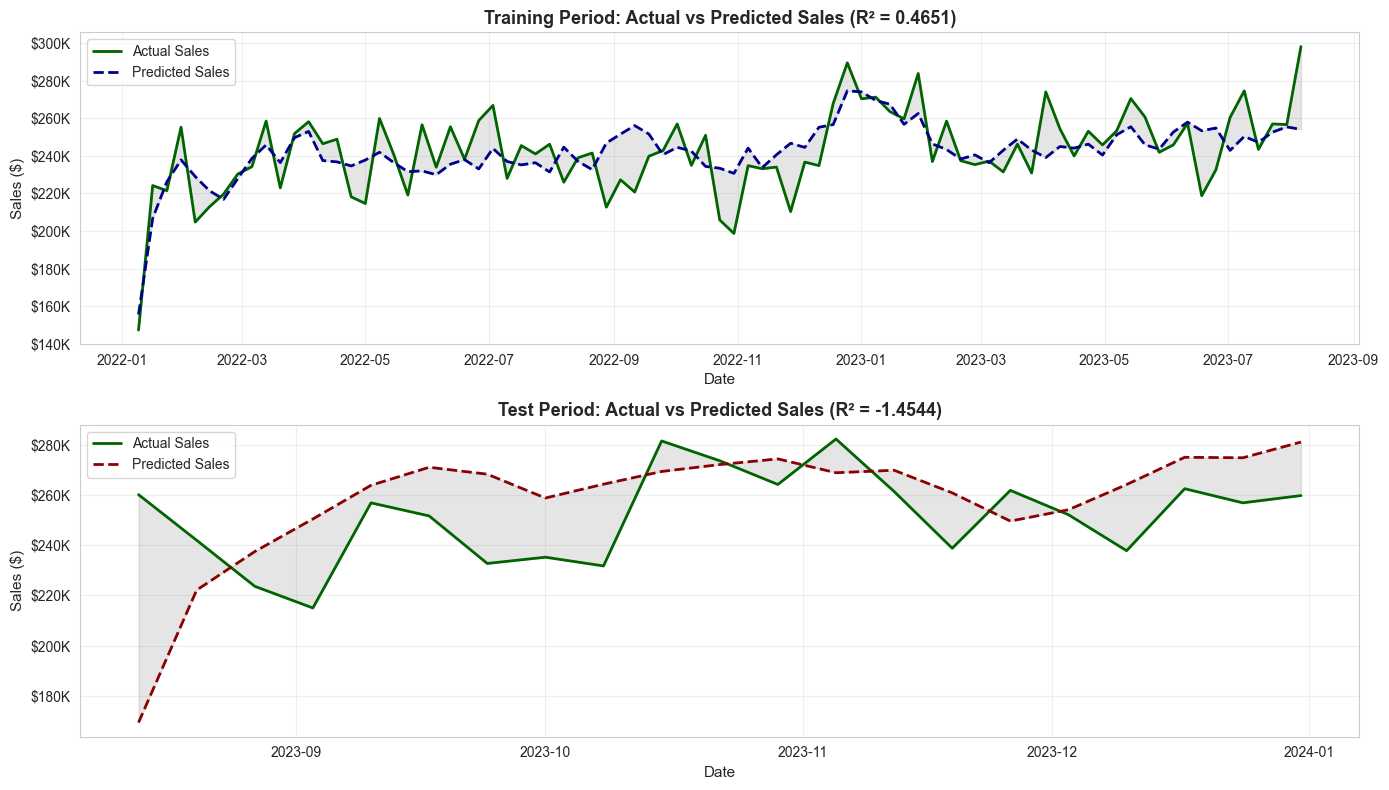


 The model captures:
   ✓ Seasonal patterns in sales
   ✓ Impact of marketing spend changes
   ✓ Carryover effects from previous periods
   ✓ Diminishing returns at high spend levels


In [30]:
# Visualize actual vs predicted sales
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Training period
axes[0].plot(train_data['date'], train_data['sales'], label='Actual Sales', linewidth=2, color='darkgreen')
axes[0].plot(train_data['date'], train_predictions, label='Predicted Sales', linewidth=2, color='darkblue', linestyle='--')
axes[0].fill_between(train_data['date'], train_data['sales'], train_predictions, alpha=0.2, color='gray')
axes[0].set_xlabel('Date', fontsize=11)
axes[0].set_ylabel('Sales ($)', fontsize=11)
axes[0].set_title(f'Training Period: Actual vs Predicted Sales (R² = {train_r2:.4f})', fontsize=13, fontweight='bold')
axes[0].legend(loc='upper left', fontsize=10)
axes[0].grid(True, alpha=0.3)
axes[0].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))

# Test period
axes[1].plot(test_data['date'], test_data['sales'], label='Actual Sales', linewidth=2, color='darkgreen')
axes[1].plot(test_data['date'], test_predictions, label='Predicted Sales', linewidth=2, color='darkred', linestyle='--')
axes[1].fill_between(test_data['date'], test_data['sales'], test_predictions, alpha=0.2, color='gray')
axes[1].set_xlabel('Date', fontsize=11)
axes[1].set_ylabel('Sales ($)', fontsize=11)
axes[1].set_title(f'Test Period: Actual vs Predicted Sales (R² = {test_r2:.4f})', fontsize=13, fontweight='bold')
axes[1].legend(loc='upper left', fontsize=10)
axes[1].grid(True, alpha=0.3)
axes[1].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))

plt.tight_layout()
plt.show()

print("\n The model captures:")
print("   ✓ Seasonal patterns in sales")
print("   ✓ Impact of marketing spend changes")
print("   ✓ Carryover effects from previous periods")
print("   ✓ Diminishing returns at high spend levels")

---

<a id='section3'></a>
## 3. Understanding MTA: Bottom-up Approach for Customer Journeys

### What is Multi-Touch Attribution?

**Multi-Touch Attribution (MTA)** analyzes individual customer journeys to understand which touchpoints contribute to conversions.

### Core Concepts

#### 1. **Customer Journey**
- Sequence of interactions a customer has with your brand
- Example: Social Ad → Email → Search → Website → Conversion

#### 2. **Touchpoint**
- Any interaction point: ad click, email open, website visit, etc.
- Can be online (trackable) or offline (harder to track)

#### 3. **Attribution Models**
Different ways to assign credit:

**Single-Touch Models:**
- **Last-Touch**: 100% credit to final interaction
- **First-Touch**: 100% credit to initial interaction

**Multi-Touch Models:**
- **Linear**: Equal credit to all touchpoints
- **Time-Decay**: More credit to recent touchpoints
- **Position-Based (U-Shaped)**: 40% to first, 40% to last, 20% to middle
- **Data-Driven**: ML-based attribution using historical data

### When to Use MTA

✅ **Best for:**
- Digital-first businesses
- Short sales cycles
- Real-time campaign optimization
- Understanding customer paths to conversion
- A/B testing and experimentation

❌ **Not ideal for:**
- Heavy offline presence
- Long sales cycles (months/years)
- Limited tracking capabilities
- When cookie/tracking data is sparse

### Let's Implement MTA Models!

In [31]:
# Generate realistic customer journey data
# This simulates clickstream data for an e-commerce company

np.random.seed(42)
n_customers = 1000

# Define available touchpoints
touchpoint_types = [
    'Social Media Ad',
    'Search Ad',
    'Display Ad',
    'Email',
    'Organic Search',
    'Direct',
    'Referral',
    'Video Ad'
]

# Generate customer journeys
customer_journeys = []

for customer_id in range(n_customers):
    # Random journey length (1-8 touchpoints)
    journey_length = np.random.choice([1, 2, 3, 4, 5, 6, 7, 8], 
                                     p=[0.05, 0.15, 0.25, 0.25, 0.15, 0.10, 0.03, 0.02])
    
    # Generate journey
    journey = []
    for i in range(journey_length):
        # First touchpoint has different distribution
        if i == 0:
            touchpoint = np.random.choice(
                ['Social Media Ad', 'Search Ad', 'Organic Search', 'Direct'],
                p=[0.35, 0.30, 0.25, 0.10]
            )
        else:
            touchpoint = np.random.choice(touchpoint_types)
        
        journey.append(touchpoint)
    
    # Conversion value (higher for longer journeys, with some randomness)
    base_value = 100
    journey_multiplier = 1 + (journey_length - 1) * 0.15
    conversion_value = base_value * journey_multiplier * np.random.uniform(0.8, 1.5)
    
    customer_journeys.append({
        'customer_id': customer_id,
        'journey': journey,
        'journey_length': journey_length,
        'conversion_value': conversion_value,
        'first_touch': journey[0],
        'last_touch': journey[-1]
    })

# Convert to DataFrame
journey_df = pd.DataFrame(customer_journeys)

print(" Customer Journey Dataset")
print("="*70)
print(f"Total Customers: {len(journey_df):,}")
print(f"Average Journey Length: {journey_df['journey_length'].mean():.2f} touchpoints")
print(f"Total Conversion Value: ${journey_df['conversion_value'].sum():,.0f}")
print(f"Average Conversion Value: ${journey_df['conversion_value'].mean():.2f}")
print(f"\nSample Customer Journeys:\n")

# Display sample journeys
for idx in range(5):
    journey = journey_df.iloc[idx]
    journey_str = ' → '.join(journey['journey'])
    print(f"Customer {journey['customer_id']}: {journey_str}")
    print(f"  Value: ${journey['conversion_value']:.2f}\n")

 Customer Journey Dataset
Total Customers: 1,000
Average Journey Length: 3.86 touchpoints
Total Conversion Value: $165,215
Average Conversion Value: $165.22

Sample Customer Journeys:

Customer 0: Direct → Display Ad → Video Ad
  Value: $158.48

Customer 1: Social Media Ad → Display Ad
  Value: $128.97

Customer 2: Social Media Ad → Display Ad → Direct
  Value: $109.13

Customer 3: Direct → Search Ad → Video Ad → Email → Organic Search
  Value: $197.16

Customer 4: Social Media Ad → Social Media Ad → Social Media Ad → Display Ad
  Value: $178.10



### 🔄 Transitioning from MMM to MTA: A Different Lens

We've just explored **Marketing Mix Modeling** - now let's shift to **Multi-Touch Attribution**.

#### **Key Differences in Approach:**

| Aspect | MMM (Previous Section) | MTA (This Section) |
|--------|----------------------|-------------------|
| **Data Level** | Aggregate (weekly totals) | Individual (customer journeys) |
| **Question** | "How much did TV contribute overall?" | "Which touchpoints led THIS customer to convert?" |
| **Data Structure** | Rows = Time periods | Rows = Individual customers |
| **Granularity** | Channel-level spend | Specific ad clicks/interactions |

#### **What is a "Customer Journey"?**

**Example Journey:**
```
Day 1: Sees Facebook Ad → Clicks
Day 3: Opens marketing email
Day 5: Searches on Google → Clicks ad
Day 6: Visits website directly → Converts!
```

**Question**: Which touchpoint(s) should get credit for the conversion?
- Facebook (started the journey)?
- Email (kept them engaged)?
- Google Search (brought them back)?
- Direct visit (closed the sale)?

**MTA's job**: Assign credit across these touchpoints fairly.

#### **Data Structure Change:**

**MMM data:**
```
Week | TV_Spend | Digital_Spend | Sales
  1  | $30,000  | $20,000       | $150,000
```

**MTA data:**
```
Customer | Journey                          | Conversion_Value
   001   | [Social Ad → Email → Direct]     | $125
   002   | [Search → Display → Search]      | $89
```

#### **Why This Matters:**

MMM tells you "Spend more on Digital" (strategic).
MTA tells you "Social ads work best for acquiring new customers" (tactical).

Let's generate realistic customer journey data:

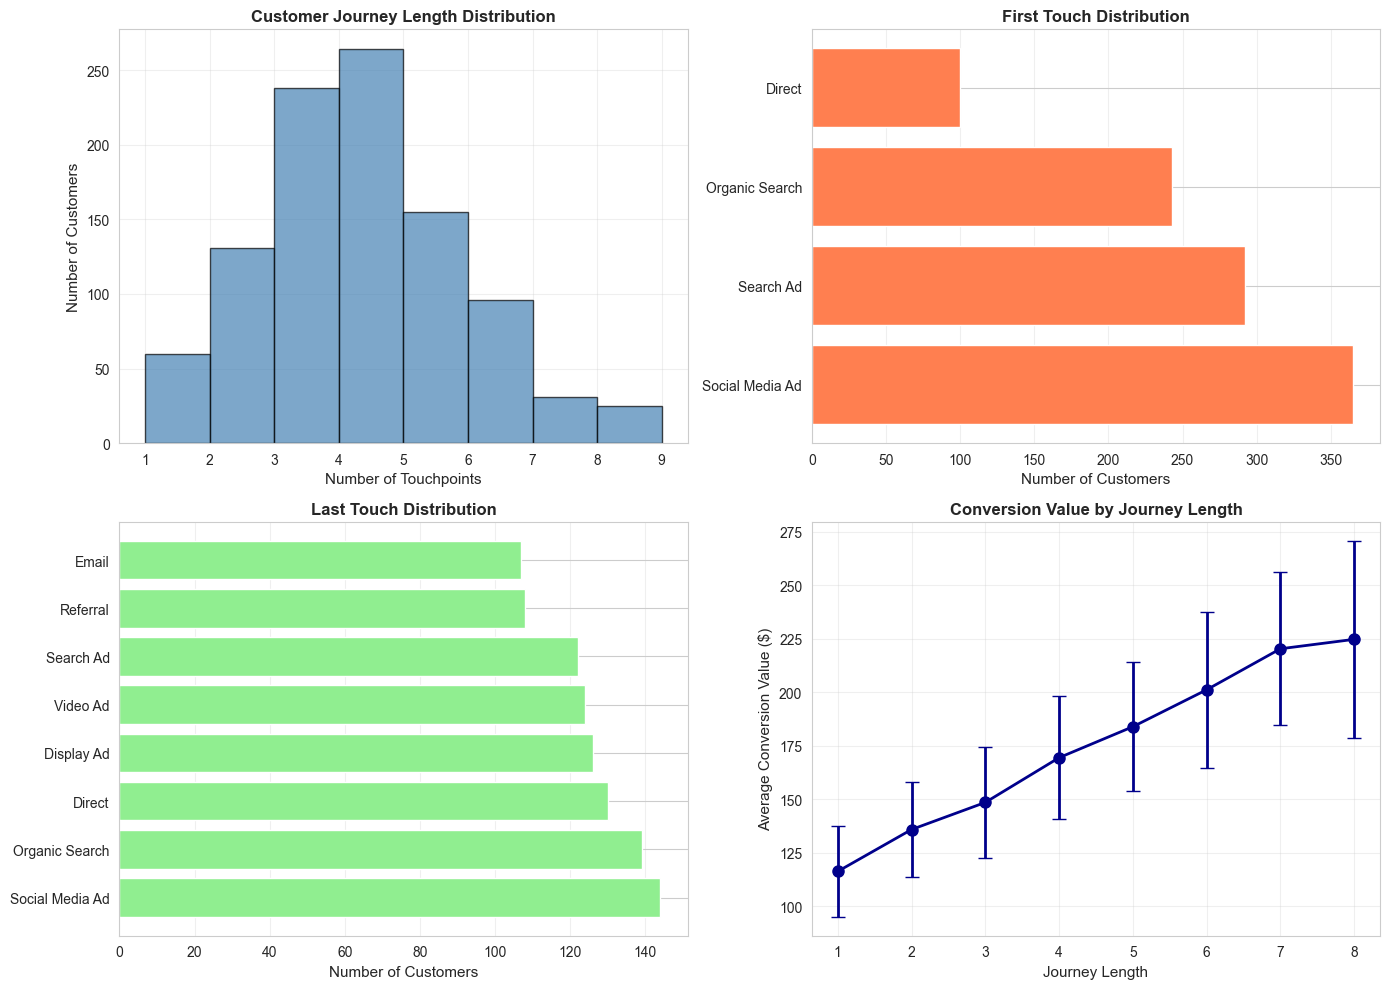


💡 Key Observations:
   • Most common journey length: 4 touchpoints
   • Top first-touch channel: Social Media Ad
   • Top last-touch channel: Social Media Ad
   • Longer journeys tend to have higher conversion values


In [32]:
# Visualize journey patterns
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Journey length distribution
axes[0, 0].hist(journey_df['journey_length'], bins=range(1, 10), 
               color='steelblue', edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Number of Touchpoints', fontsize=11)
axes[0, 0].set_ylabel('Number of Customers', fontsize=11)
axes[0, 0].set_title('Customer Journey Length Distribution', fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# First touch distribution
first_touch_counts = journey_df['first_touch'].value_counts()
axes[0, 1].barh(first_touch_counts.index, first_touch_counts.values, color='coral')
axes[0, 1].set_xlabel('Number of Customers', fontsize=11)
axes[0, 1].set_title('First Touch Distribution', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, axis='x')

# Last touch distribution
last_touch_counts = journey_df['last_touch'].value_counts()
axes[1, 0].barh(last_touch_counts.index, last_touch_counts.values, color='lightgreen')
axes[1, 0].set_xlabel('Number of Customers', fontsize=11)
axes[1, 0].set_title('Last Touch Distribution', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='x')

# Conversion value vs journey length
journey_value_avg = journey_df.groupby('journey_length')['conversion_value'].agg(['mean', 'std']).reset_index()
axes[1, 1].errorbar(journey_value_avg['journey_length'], journey_value_avg['mean'], 
                   yerr=journey_value_avg['std'], marker='o', markersize=8,
                   linewidth=2, capsize=5, color='darkblue')
axes[1, 1].set_xlabel('Journey Length', fontsize=11)
axes[1, 1].set_ylabel('Average Conversion Value ($)', fontsize=11)
axes[1, 1].set_title('Conversion Value by Journey Length', fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n💡 Key Observations:")
print(f"   • Most common journey length: {journey_df['journey_length'].mode()[0]} touchpoints")
print(f"   • Top first-touch channel: {first_touch_counts.index[0]}")
print(f"   • Top last-touch channel: {last_touch_counts.index[0]}")
print(f"   • Longer journeys tend to have higher conversion values")

### Implementing Attribution Models

Let's implement different attribution models and compare their results.

In [33]:
# Multi-Touch Attribution Model Class
class MultiTouchAttribution:
    """
    Implementation of various Multi-Touch Attribution models.
    """
    
    @staticmethod
    def last_touch(touchpoints, conversion_value):
        """
        Last-Touch Attribution: All credit to the final touchpoint.
        
        Use case: When you want to focus on closing the sale.
        """
        attribution = {tp: 0 for tp in set(touchpoints)}
        if touchpoints:
            attribution[touchpoints[-1]] = conversion_value
        return attribution
    
    @staticmethod
    def first_touch(touchpoints, conversion_value):
        """
        First-Touch Attribution: All credit to the initial touchpoint.
        
        Use case: When you want to focus on customer acquisition.
        """
        attribution = {tp: 0 for tp in set(touchpoints)}
        if touchpoints:
            attribution[touchpoints[0]] = conversion_value
        return attribution
    
    @staticmethod
    def linear(touchpoints, conversion_value):
        """
        Linear Attribution: Equal credit to all touchpoints.
        
        Use case: When all touchpoints are equally important.
        """
        attribution = {tp: 0 for tp in set(touchpoints)}
        if touchpoints:
            credit_per_touch = conversion_value / len(touchpoints)
            for tp in touchpoints:
                attribution[tp] += credit_per_touch
        return attribution
    
    @staticmethod
    def time_decay(touchpoints, conversion_value, decay_rate=0.5):
        """
        Time-Decay Attribution: More credit to recent touchpoints.
        
        Use case: When recent interactions are more important (short sales cycle).
        
        Parameters:
        -----------
        decay_rate : float
            How quickly credit decays for older touchpoints (0-1).
            Higher = more credit to recent.
        """
        attribution = {tp: 0 for tp in set(touchpoints)}
        
        if touchpoints:
            n = len(touchpoints)
            # Calculate weights (exponential decay from end)
            weights = [decay_rate ** (n - i - 1) for i in range(n)]
            total_weight = sum(weights)
            
            for i, tp in enumerate(touchpoints):
                attribution[tp] += conversion_value * (weights[i] / total_weight)
        
        return attribution
    
    @staticmethod
    def position_based(touchpoints, conversion_value, first_last_weight=0.4):
        """
        Position-Based (U-Shaped) Attribution.
        More credit to first and last touchpoints.
        
        Use case: When both acquisition and conversion touchpoints are critical.
        
        Parameters:
        -----------
        first_last_weight : float
            Weight for first and last touchpoints (default 40% each).
        """
        attribution = {tp: 0 for tp in set(touchpoints)}
        
        if not touchpoints:
            return attribution
        
        n = len(touchpoints)
        
        if n == 1:
            attribution[touchpoints[0]] = conversion_value
        elif n == 2:
            attribution[touchpoints[0]] += conversion_value * 0.5
            attribution[touchpoints[1]] += conversion_value * 0.5
        else:
            # 40% to first, 40% to last, 20% distributed to middle
            middle_weight = 1 - 2 * first_last_weight
            middle_per_touch = middle_weight / (n - 2)
            
            attribution[touchpoints[0]] += conversion_value * first_last_weight
            attribution[touchpoints[-1]] += conversion_value * first_last_weight
            
            for tp in touchpoints[1:-1]:
                attribution[tp] += conversion_value * middle_per_touch
        
        return attribution

print(" MultiTouchAttribution class defined successfully!")

 MultiTouchAttribution class defined successfully!


### 🎯 The Credit Assignment Problem in Attribution

Now we'll implement different attribution models. But first, understand the fundamental challenge:

#### **The Problem: Who Gets Credit?**

**Scenario**: A customer's journey to a $100 purchase:
```
Social Media Ad → Email → Search Ad → Direct Visit → Purchase ($100)
```

**The Question**: How do we split the $100 credit among these 4 touchpoints?

There's **no single "correct" answer** - it depends on your business goals!

#### **Attribution Models: Different Philosophies**

**1. Last-Touch Attribution**
- **Philosophy**: "Closers win games"
- **Credit**: Direct Visit gets $100, others get $0
- **When to use**: Focus on conversion optimization
- **Limitation**: Ignores the journey that brought them there

**2. First-Touch Attribution**
- **Philosophy**: "Discovery is everything"
- **Credit**: Social Media Ad gets $100, others get $0
- **When to use**: Focus on customer acquisition
- **Limitation**: Ignores nurturing and conversion touches

**3. Linear Attribution**
- **Philosophy**: "Everyone contributes equally"
- **Credit**: Each touchpoint gets $25 ($100 ÷ 4)
- **When to use**: Democratic view of the journey
- **Limitation**: Treats all touches as equal (unrealistic)

**4. Time-Decay Attribution**
- **Philosophy**: "Recent touches matter more"
- **Credit**: Direct Visit $40, Search $30, Email $20, Social $10
- **When to use**: Short sales cycles where recency matters
- **Limitation**: May undervalue early awareness

**5. Position-Based (U-Shaped) Attribution**
- **Philosophy**: "First and last touches are critical"
- **Credit**: Social $40, Email $10, Search $10, Direct $40
- **When to use**: Value both acquisition AND conversion
- **Limitation**: Arbitrary 40-40-20 split

#### **No "Right" Answer**

Each model answers a different question:
- Last-touch → "What closed the deal?"
- First-touch → "What brought them in?"
- Linear → "What's everyone's contribution?"
- Time-decay → "What mattered lately?"
- Position-based → "What acquired and converted?"

**Best practice**: Calculate multiple models and compare results. Where they agree, you can be more confident.

Let's implement all of them:

In [34]:
# Apply all attribution models to the data
def calculate_channel_attribution(journeys_df, attribution_model):
    """
    Calculate total attribution for each channel using specified model.
    """
    total_attribution = {}
    
    for _, row in journeys_df.iterrows():
        journey = row['journey']
        value = row['conversion_value']
        
        # Get attribution for this journey
        journey_attribution = attribution_model(journey, value)
        
        # Add to total
        for channel, attr_value in journey_attribution.items():
            total_attribution[channel] = total_attribution.get(channel, 0) + attr_value
    
    return total_attribution

# Apply each attribution model
print(" Calculating attributions using different models...\n")

mta = MultiTouchAttribution()

attribution_results = {
    'Last Touch': calculate_channel_attribution(journey_df, mta.last_touch),
    'First Touch': calculate_channel_attribution(journey_df, mta.first_touch),
    'Linear': calculate_channel_attribution(journey_df, mta.linear),
    'Time Decay': calculate_channel_attribution(journey_df, lambda tp, val: mta.time_decay(tp, val, 0.6)),
    'Position-Based': calculate_channel_attribution(journey_df, mta.position_based)
}

# Convert to DataFrame for easier comparison
attribution_comparison = pd.DataFrame(attribution_results).fillna(0)
attribution_comparison_pct = attribution_comparison.div(attribution_comparison.sum(axis=0), axis=1) * 100

print(" Total Attributed Value by Channel and Model:\n")
print(attribution_comparison.round(0).to_string())
print("\n Attribution Percentage by Channel and Model:\n")
print(attribution_comparison_pct.round(1).to_string())

print("\n Attribution models calculated successfully!")

 Calculating attributions using different models...

 Total Attributed Value by Channel and Model:

                 Last Touch  First Touch   Linear  Time Decay  Position-Based
Direct              21348.0      16413.0  19597.0     20165.0         19086.0
Video Ad            21037.0          0.0  14334.0     17464.0         11992.0
Display Ad          21614.0          0.0  13596.0     16986.0         11829.0
Social Media Ad     22607.0      59238.0  33223.0     27874.0         37958.0
Search Ad           19686.0      48774.0  28480.0     24067.0         32032.0
Email               17806.0          0.0  14228.0     16272.0         10876.0
Organic Search      22497.0      40791.0  27625.0     25583.0         30191.0
Referral            18621.0          0.0  14133.0     16803.0         11251.0

 Attribution Percentage by Channel and Model:

                 Last Touch  First Touch  Linear  Time Decay  Position-Based
Direct                 12.9          9.9    11.9        12.2            1

### 🔍 Comparing Attribution Models: What to Look For

Now we'll apply all five attribution models to our data and compare results.

#### **What to Expect:**

**1. Different models will give VERY different results**
- This is normal and expected!
- It reflects different business philosophies
- No single model is "truth" - they're different lenses

**2. Patterns to notice:**

**Channel Performance Variability:**
- **Social Media**: High in first-touch, lower in last-touch
  - Why? It's often the discovery channel
- **Direct Traffic**: High in last-touch, lower in first-touch
  - Why? People return directly to convert
- **Email**: Moderate across models
  - Why? It's often a mid-journey touchpoint

**3. How to interpret disagreements:**

If a channel scores high in:
- **First-touch only** → Good for awareness/acquisition
- **Last-touch only** → Good for conversion/closing
- **All models** → Consistently valuable across the journey
- **None** → May need optimization or reconsideration

#### **Business Use Cases:**

**Scenario 1: Optimizing for new customer acquisition**
→ Use First-Touch attribution
→ Invest in top-performing awareness channels

**Scenario 2: Improving conversion rates**
→ Use Last-Touch attribution  
→ Optimize bottom-of-funnel channels

**Scenario 3: Balanced growth**
→ Use Position-Based or compare multiple models
→ Invest across the funnel

**Scenario 4: E-commerce with short cycles**
→ Use Time-Decay
→ Focus on recency

#### **Critical Thinking Questions:**

As you review the results, ask:
1. Do these results align with our business understanding?
2. Are there surprising differences between models?
3. Which model best fits our business model and goals?
4. Should we use different models for different purposes?

Let's calculate and compare:

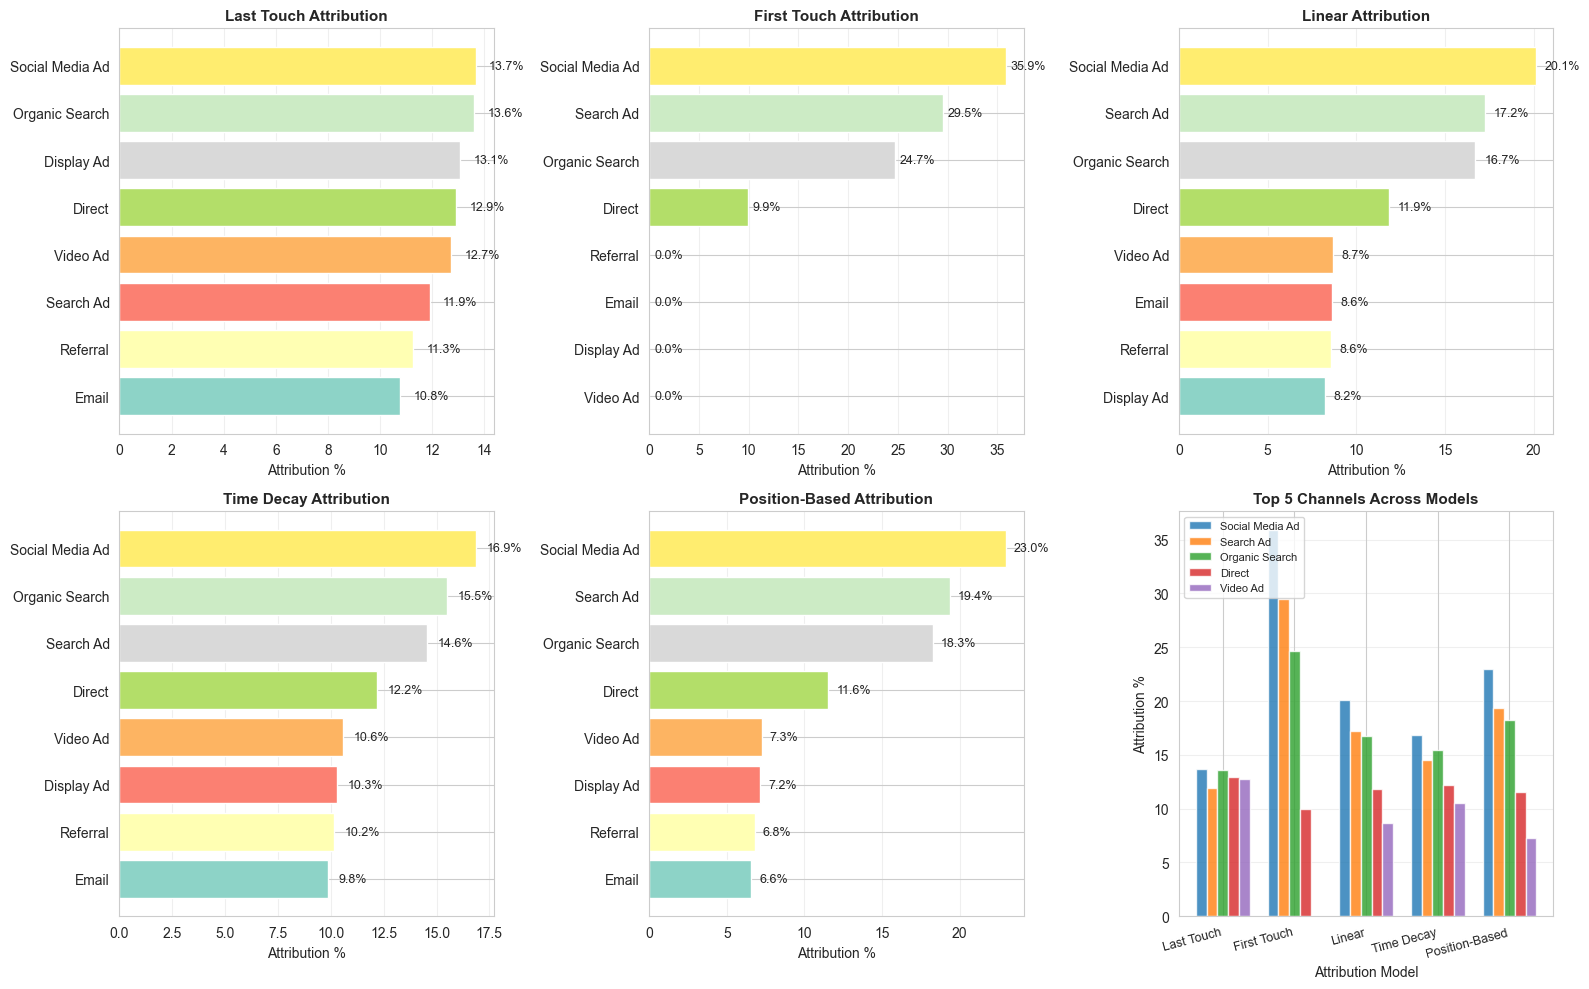


🔍 Model Comparison Insights:
   • Last Touch over-credits conversion-driving channels
   • First Touch over-credits awareness channels
   • Linear gives balanced view but may under-value key touchpoints
   • Time Decay balances recency with earlier touches
   • Position-Based emphasizes both acquisition and conversion


In [35]:
# Visualize attribution model comparison
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

models = ['Last Touch', 'First Touch', 'Linear', 'Time Decay', 'Position-Based']
colors_bar = plt.cm.Set3(np.linspace(0, 1, len(attribution_comparison)))

for idx, model in enumerate(models):
    data = attribution_comparison_pct[model].sort_values(ascending=True)
    axes[idx].barh(data.index, data.values, color=colors_bar)
    axes[idx].set_xlabel('Attribution %', fontsize=10)
    axes[idx].set_title(f'{model} Attribution', fontsize=11, fontweight='bold')
    axes[idx].grid(True, alpha=0.3, axis='x')
    
    # Add value labels
    for i, (channel, value) in enumerate(zip(data.index, data.values)):
        axes[idx].text(value + 0.5, i, f'{value:.1f}%', va='center', fontsize=9)

# Hide the 6th subplot
axes[5].axis('off')

# Add comparison in the 6th plot
comparison_data = attribution_comparison_pct.T
top_channels = attribution_comparison_pct.mean(axis=1).nlargest(5).index
x = np.arange(len(models))
width = 0.15

for i, channel in enumerate(top_channels):
    offset = width * (i - 2)
    axes[5].bar(x + offset, comparison_data[channel], width, label=channel, alpha=0.8)

axes[5].set_xlabel('Attribution Model', fontsize=10)
axes[5].set_ylabel('Attribution %', fontsize=10)
axes[5].set_title('Top 5 Channels Across Models', fontsize=11, fontweight='bold')
axes[5].set_xticks(x)
axes[5].set_xticklabels(models, rotation=15, ha='right', fontsize=9)
axes[5].legend(fontsize=8, loc='upper left')
axes[5].grid(True, alpha=0.3, axis='y')
axes[5].axis('on')

plt.tight_layout()
plt.show()

print("\n🔍 Model Comparison Insights:")
print("   • Last Touch over-credits conversion-driving channels")
print("   • First Touch over-credits awareness channels")
print("   • Linear gives balanced view but may under-value key touchpoints")
print("   • Time Decay balances recency with earlier touches")
print("   • Position-Based emphasizes both acquisition and conversion")

---

<a id='section4'></a>
## 4. Key Differences and Use Cases: MMM vs MTA

### Side-by-Side Comparison

| Aspect | Marketing Mix Modeling (MMM) | Multi-Touch Attribution (MTA) |
|--------|------------------------------|-------------------------------|
| **Approach** | Top-down, aggregate | Bottom-up, individual |
| **Data Level** | Weekly/Monthly aggregates | Customer-level journeys |
| **Time Horizon** | Long-term (2-3 years) | Short-term (days to months) |
| **Channels** | All channels (online + offline) | Primarily digital channels |
| **Data Required** | Historical spend + sales | Clickstream/journey data |
| **Update Frequency** | Quarterly/Annually | Real-time to daily |
| **Privacy Concerns** | Low (aggregated) | Higher (individual tracking) |
| **Implementation Cost** | Medium to High | Medium |
| **Accuracy** | Good for macro trends | Good for digital optimization |
| **Best For** | Budget planning, offline media | Digital optimization, testing |

### When to Use Each Approach

#### Choose **MMM** when:
- 📺 You have significant offline marketing (TV, Radio, Print)
- 📅 Long-term strategic planning is the priority
- 🔒 Privacy regulations limit individual tracking
- 📊 You lack granular customer journey data
- 💰 Budget allocation across channels is the main question
- 🌍 Multi-market analysis is needed

#### Choose **MTA** when:
- 💻 Your business is primarily digital
- ⚡ Real-time optimization is critical
- 🎯 You want to understand customer paths
- 🔬 A/B testing and experimentation are important
- 🚀 Short sales cycles dominate
- 📱 You have robust tracking infrastructure

#### Use **Both** when:
- 🎭 You have significant online AND offline presence
- 🔄 You need both strategic and tactical insights
- 💪 You have resources for comprehensive analytics
- 📈 Omnichannel strategy is a priority

### The Future: Unified Measurement

Modern approaches are combining MMM and MTA:
- **Unified Marketing Measurement (UMM)**
- Privacy-friendly attribution (with iOS 14+, GDPR, etc.)
- Media Mix Modeling with customer journey insights
- Incrementality testing to validate both approaches

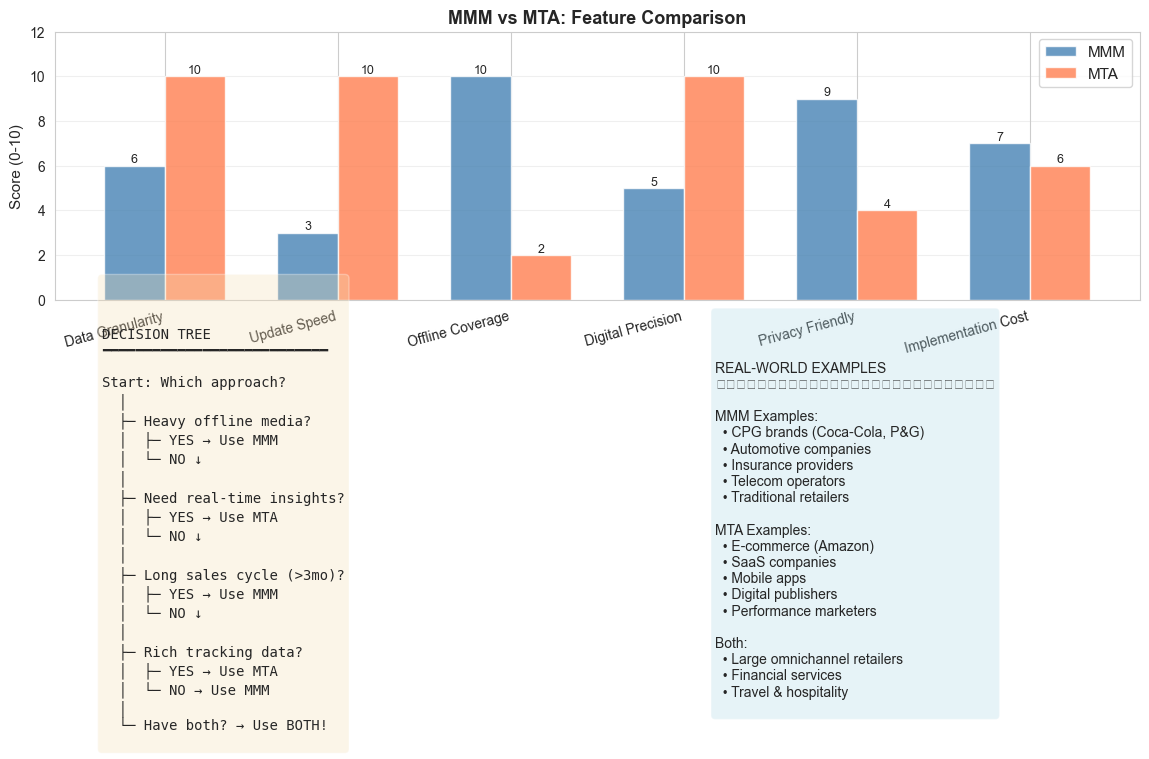


 MMM and MTA serve different but complementary purposes!
   Choose based on your business needs, data availability, and objectives.


In [36]:
# Visualize MMM vs MTA comparison
fig = plt.figure(figsize=(14, 8))
gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.3)

# Comparison matrix
ax1 = fig.add_subplot(gs[0, :])

comparison_data = {
    'Criteria': ['Data Granularity', 'Update Speed', 'Offline Coverage', 
                'Digital Precision', 'Privacy Friendly', 'Implementation Cost'],
    'MMM': [6, 3, 10, 5, 9, 7],
    'MTA': [10, 10, 2, 10, 4, 6]
}

df_comparison = pd.DataFrame(comparison_data)
x = np.arange(len(df_comparison['Criteria']))
width = 0.35

bars1 = ax1.bar(x - width/2, df_comparison['MMM'], width, label='MMM', color='steelblue', alpha=0.8)
bars2 = ax1.bar(x + width/2, df_comparison['MTA'], width, label='MTA', color='coral', alpha=0.8)

ax1.set_ylabel('Score (0-10)', fontsize=11)
ax1.set_title('MMM vs MTA: Feature Comparison', fontsize=13, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(df_comparison['Criteria'], rotation=15, ha='right')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3, axis='y')
ax1.set_ylim(0, 12)

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}', ha='center', va='bottom', fontsize=9)

# Decision tree
ax2 = fig.add_subplot(gs[1, 0])
ax2.axis('off')

decision_text = """


DECISION TREE
━━━━━━━━━━━━━━━━━━━━━━━━━━━

Start: Which approach?
  │
  ├─ Heavy offline media?
  │  ├─ YES → Use MMM
  │  └─ NO ↓
  │
  ├─ Need real-time insights?
  │  ├─ YES → Use MTA
  │  └─ NO ↓
  │
  ├─ Long sales cycle (>3mo)?
  │  ├─ YES → Use MMM
  │  └─ NO ↓
  │
  ├─ Rich tracking data?
  │  ├─ YES → Use MTA
  │  └─ NO → Use MMM
  │
  └─ Have both? → Use BOTH!
"""

ax2.text(0.1, 0.5, decision_text, fontsize=10, family='monospace',
        verticalalignment='center', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

# Use case examples
ax3 = fig.add_subplot(gs[1, 1])
ax3.axis('off')

use_cases_text = """


REAL-WORLD EXAMPLES
━━━━━━━━━━━━━━━━━━━━━━━━━━━

MMM Examples:
  • CPG brands (Coca-Cola, P&G)
  • Automotive companies
  • Insurance providers
  • Telecom operators
  • Traditional retailers

MTA Examples:
  • E-commerce (Amazon)
  • SaaS companies
  • Mobile apps
  • Digital publishers
  • Performance marketers

Both:
  • Large omnichannel retailers
  • Financial services
  • Travel & hospitality
"""

ax3.text(0.1, 0.5, use_cases_text, fontsize=10,
        verticalalignment='center', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.3))

plt.show()

print("\n MMM and MTA serve different but complementary purposes!")
print("   Choose based on your business needs, data availability, and objectives.")

### 🤔 How to Read the Comparison Table

You're about to see a side-by-side comparison of MMM and MTA. Here's how to interpret it:

#### **Understanding the Scores (0-10 Scale)**

**Data Granularity:**
- MMM: 6/10 (weekly/monthly aggregates)
- MTA: 10/10 (individual customer journeys)
- **Insight**: MTA wins if you need detailed insights

**Update Speed:**
- MMM: 3/10 (quarterly updates typical)
- MTA: 10/10 (can be real-time)
- **Insight**: MTA wins for fast-moving campaigns

**Offline Coverage:**
- MMM: 10/10 (includes TV, Radio, Print)
- MTA: 2/10 (mainly digital only)
- **Insight**: MMM wins for multi-channel businesses

**Digital Precision:**
- MMM: 5/10 (groups digital channels)
- MTA: 10/10 (tracks individual clicks)
- **Insight**: MTA wins for digital optimization

**Privacy Friendly:**
- MMM: 9/10 (no individual tracking)
- MTA: 4/10 (requires customer tracking)
- **Insight**: MMM wins in privacy-first environments

#### **The Decision Framework:**

**Step 1: Identify your constraints**
- Do you have offline channels? → Lean MMM
- Need real-time decisions? → Lean MTA
- Privacy regulations strict? → Lean MMM
- Digital-only business? → Lean MTA

**Step 2: Consider your resources**
- Limited tracking infrastructure? → MMM easier
- Strong data engineering team? → MTA possible
- Need both? → Plan for complementary approaches

**Step 3: Match to business objectives**
- Strategic planning (annual budgets)? → MMM
- Tactical optimization (campaign tweaks)? → MTA
- Comprehensive understanding? → Both

#### **The "Both" Scenario**

Many sophisticated organizations use both:
- **MMM** for quarterly planning and budget allocation
- **MTA** for daily campaign optimization and testing

They complement each other:
- MMM provides strategic direction
- MTA enables tactical execution
- Together, they create a complete picture

Let's visualize the comparison:

---

<a id='section5'></a>
## 5. Practical Considerations for Implementation and Interpretation

### Common Challenges and Solutions

#### Challenge 1: Data Quality
**Problem:**
- Missing data, inconsistent tracking, data silos
- MMM: Incomplete spend data, sales reporting gaps
- MTA: Cookie deletion, cross-device tracking issues

**Solutions:**
- Invest in data infrastructure and governance
- Use data imputation techniques for missing values
- Implement server-side tracking where possible
- Regular data quality audits

#### Challenge 2: Multi-Collinearity
**Problem:**
- Marketing channels are often correlated
- Hard to isolate individual channel effects

**Solutions:**
- Use regularization (Ridge/Lasso regression)
- Consider variance inflation factor (VIF)
- Design experiments to vary channels independently
- Bayesian methods for uncertainty quantification

#### Challenge 3: Attribution Window
**Problem:**
- How long after seeing an ad can we credit it?
- Too short: miss delayed conversions
- Too long: over-credit channels

**Solutions:**
- Test different windows (7, 14, 30 days)
- Segment by product/vertical
- Use survival analysis to model time-to-conversion

#### Challenge 4: External Factors
**Problem:**
- Seasonality, competitors, economy, COVID-19, etc.
- Can confound marketing effects

**Solutions:**
- Include control variables (weather, holidays, etc.)
- Use time series decomposition
- Consider difference-in-differences for events
- Synthetic control methods

#### Challenge 5: Model Validation
**Problem:**
- How do we know the model is accurate?
- Historical fit ≠ predictive accuracy

**Solutions:**
- Hold-out test sets
- Cross-validation
- Incrementality tests (geo experiments)
- Business logic sanity checks

### Best Practices

#### For MMM:
1. **Data Requirements:**
   - Minimum 2 years of weekly data
   - Include all relevant channels
   - Account for seasonality and trends

2. **Model Building:**
   - Start simple, add complexity gradually
   - Test different adstock decay rates
   - Validate saturation curves make business sense
   - Use regularization to prevent overfitting

3. **Interpretation:**
   - Focus on relative contributions, not absolute
   - Check if ROI estimates align with business knowledge
   - Consider confidence intervals
   - Update models regularly (quarterly)

#### For MTA:
1. **Data Requirements:**
   - Comprehensive tracking across channels
   - User ID resolution (cross-device)
   - Clean data pipeline

2. **Model Selection:**
   - Start with simple models (last-touch)
   - Compare multiple models
   - Consider data-driven attribution if volume permits
   - Segment by customer type/product

3. **Interpretation:**
   - Validate against incrementality tests
   - Consider journey patterns, not just attribution
   - Account for view-through vs click-through
   - Monitor model stability over time

### Incrementality Testing: The Gold Standard

Both MMM and MTA have limitations. **Incrementality testing** provides ground truth:

- **Geo Experiments:** Turn off marketing in test markets
- **Holdout Tests:** Exclude random users from campaigns
- **A/B Tests:** Randomized experiments

Use incrementality tests to:
- Validate MMM/MTA models
- Calibrate attribution models
- Measure true causal impact

🔍 Model Diagnostics and Validation



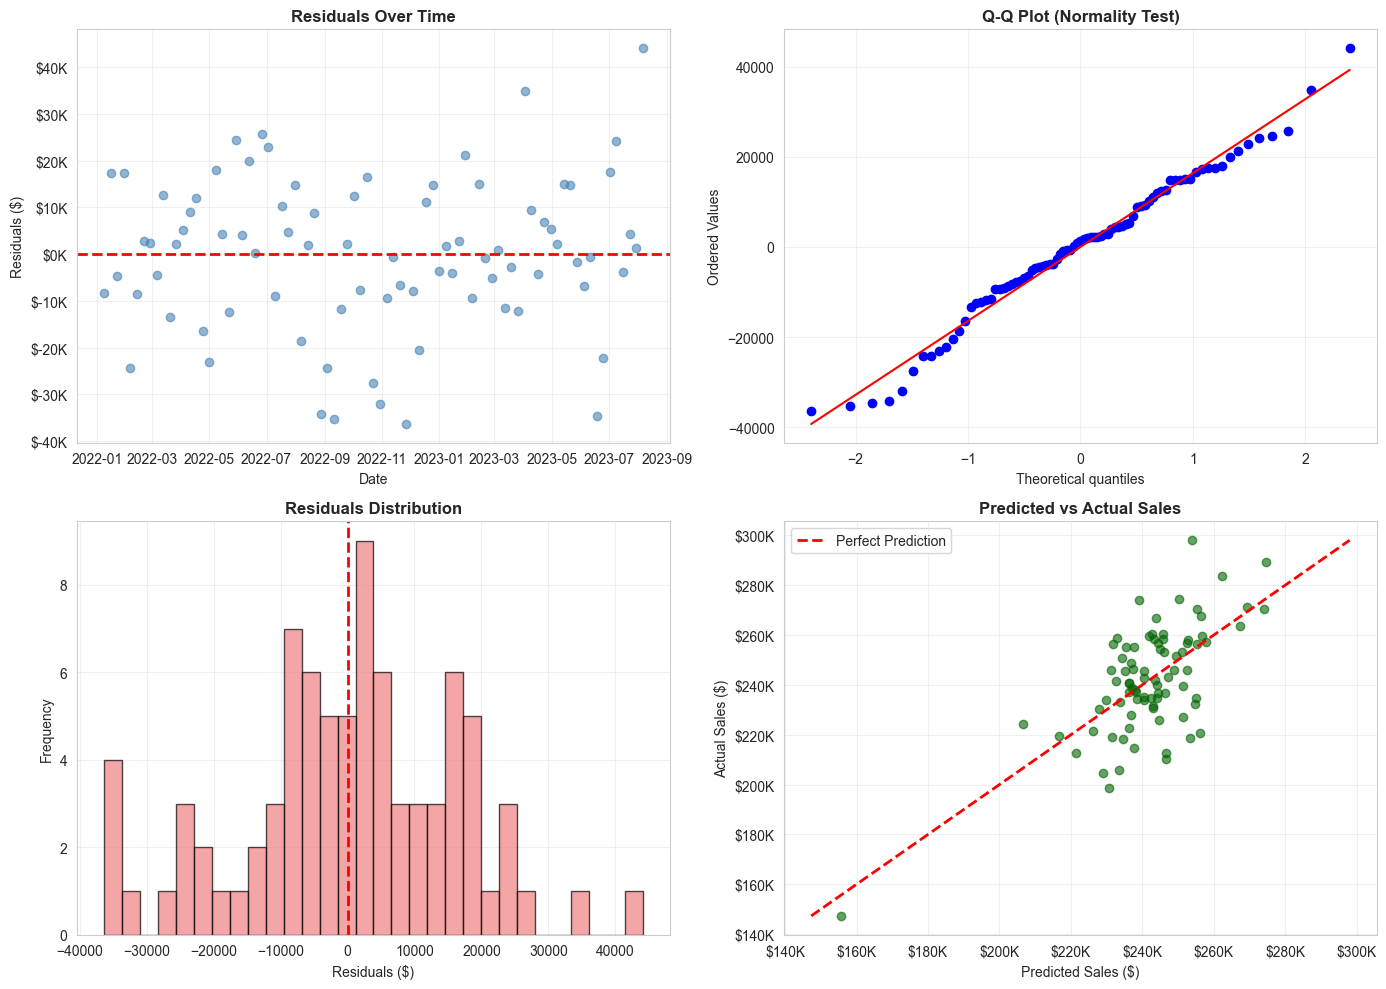


 Statistical Diagnostics:
Shapiro-Wilk Test (Normality): p-value = 0.4201
  ✓ Residuals appear normally distributed

Durbin-Watson Test (Autocorrelation): 1.6600
  (Values 1.5-2.5 suggest low autocorrelation)
  ✓ Low autocorrelation detected

Mean Absolute Percentage Error: 5.26%

 Model diagnostics completed!


In [38]:
# Practical example: Model diagnostics and validation
print("🔍 Model Diagnostics and Validation\n")
print("="*70)

# 1. Check model assumptions
from scipy import stats

# Get residuals from MMM model
train_residuals = train_data['sales'] - train_predictions

# Create diagnostic plots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Residuals over time
axes[0, 0].scatter(train_data['date'], train_residuals, alpha=0.6, color='steelblue')
axes[0, 0].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[0, 0].set_xlabel('Date', fontsize=10)
axes[0, 0].set_ylabel('Residuals ($)', fontsize=10)
axes[0, 0].set_title('Residuals Over Time', fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))

# 2. Q-Q plot (normality test)
stats.probplot(train_residuals, dist="norm", plot=axes[0, 1])
axes[0, 1].set_title('Q-Q Plot (Normality Test)', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# 3. Residuals histogram
axes[1, 0].hist(train_residuals, bins=30, color='lightcoral', edgecolor='black', alpha=0.7)
axes[1, 0].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[1, 0].set_xlabel('Residuals ($)', fontsize=10)
axes[1, 0].set_ylabel('Frequency', fontsize=10)
axes[1, 0].set_title('Residuals Distribution', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# 4. Predicted vs Actual
axes[1, 1].scatter(train_predictions, train_data['sales'], alpha=0.6, color='darkgreen')
# Perfect prediction line
min_val = min(train_predictions.min(), train_data['sales'].min())
max_val = max(train_predictions.max(), train_data['sales'].max())
axes[1, 1].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
axes[1, 1].set_xlabel('Predicted Sales ($)', fontsize=10)
axes[1, 1].set_ylabel('Actual Sales ($)', fontsize=10)
axes[1, 1].set_title('Predicted vs Actual Sales', fontsize=12, fontweight='bold')
axes[1, 1].legend(fontsize=10)
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))
axes[1, 1].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))

plt.tight_layout()
plt.show()

# Statistical tests
print("\n Statistical Diagnostics:")
print("="*70)

# Normality test
from scipy.stats import shapiro, anderson
shapiro_stat, shapiro_p = shapiro(train_residuals)
print(f"Shapiro-Wilk Test (Normality): p-value = {shapiro_p:.4f}")
if shapiro_p > 0.05:
    print("  ✓ Residuals appear normally distributed")
else:
    print("  ⚠ Residuals may not be normally distributed")

# Autocorrelation test
from statsmodels.stats.stattools import durbin_watson
dw_stat = durbin_watson(train_residuals)
print(f"\nDurbin-Watson Test (Autocorrelation): {dw_stat:.4f}")
print("  (Values 1.5-2.5 suggest low autocorrelation)")
if 1.5 <= dw_stat <= 2.5:
    print("  ✓ Low autocorrelation detected")
else:
    print("  ⚠ Significant autocorrelation may be present")

# Mean absolute percentage error
mape = np.mean(np.abs(train_residuals / train_data['sales'])) * 100
print(f"\nMean Absolute Percentage Error: {mape:.2f}%")

print("\n Model diagnostics completed!")

### 🔬 Why Model Diagnostics Matter (Don't Skip This!)

Before trusting your MMM results for million-dollar decisions, you MUST validate the model.

#### **What Can Go Wrong with MMM?**

**Problem 1: Non-Normal Residuals**
- **What it means**: Prediction errors aren't random - there's a pattern
- **Why it's bad**: Model might be systematically wrong for certain conditions
- **How to detect**: Q-Q plot should follow the diagonal line

**Problem 2: Autocorrelation**
- **What it means**: This week's error predicts next week's error
- **Why it's bad**: Your model is missing time-dependent patterns
- **How to detect**: Durbin-Watson test (want values near 2.0)

**Problem 3: Heteroscedasticity**
- **What it means**: Prediction errors vary with sales level (e.g., worse for high sales)
- **Why it's bad**: Confidence intervals are wrong
- **How to detect**: Residuals plot should show random scatter

**Problem 4: Model Bias**
- **What it means**: Consistently over- or under-predicting
- **Why it's bad**: ROI calculations will be systematically wrong
- **How to detect**: Residuals should center around zero

#### **Reading the Diagnostic Plots:**

**1. Residuals Over Time (Top-Left)**
- **Good**: Random scatter around zero
- **Bad**: Patterns, trends, or clusters
- **Action if bad**: Add time-based features (trends, seasonality)

**2. Q-Q Plot (Top-Right)**
- **Good**: Points follow the diagonal line
- **Bad**: Curves or deviations at extremes
- **Action if bad**: Transform target variable or check for outliers

**3. Residuals Histogram (Bottom-Left)**
- **Good**: Bell-shaped, centered at zero
- **Bad**: Skewed, multiple peaks, or heavy tails
- **Action if bad**: Check for missing variables or outliers

**4. Predicted vs Actual (Bottom-Right)**
- **Good**: Points cluster tightly around red line
- **Bad**: Systematic deviations (consistently above/below line)
- **Action if bad**: Model may be mis-specified

#### **Statistical Tests Interpretation:**

**Shapiro-Wilk Test (Normality):**
- p-value > 0.05 → Residuals are normal ✓
- p-value < 0.05 → Non-normal residuals ⚠️
- **Note**: With large samples, small deviations become "significant" - use plots too!

**Durbin-Watson Test (Autocorrelation):**
- Value near 2.0 → No autocorrelation ✓
- Value near 0 → Positive autocorrelation ⚠️
- Value near 4 → Negative autocorrelation ⚠️
- **Range**: 1.5-2.5 is generally acceptable

#### **When to Worry:**

🚨 **Red flags** (must address):
- Durbin-Watson < 1.0 or > 3.0
- Clear patterns in residuals over time
- R² on test set much worse than training

⚠️ **Yellow flags** (investigate):
- MAPE > 15%
- Slight non-normality in residuals
- A few outliers

✅ **Green flags** (you're good):
- Random residuals
- Good train/test match
- Business-sensible results

Let's check our model's health:

---

<a id='section6'></a>
## 6. Hands-On Exercise: Budget Optimization

### Scenario:
You're a Marketing Analytics Manager at an e-commerce company. You have:
- Annual marketing budget: $5 million
- Goal: Maximize ROI while maintaining brand presence
- Constraints: Minimum spend requirements for brand channels

### Task:
Use the MMM model to optimize budget allocation and create a recommendation.

 Budget Optimization Exercise

 Current Annual Spend:
----------------------------------------------------------------------
Tv              $   2,931,533  ( 42.2%)
Digital         $   1,771,488  ( 25.5%)
Radio           $     813,208  ( 11.7%)
Social          $     730,452  ( 10.5%)
Print           $     700,323  ( 10.1%)
----------------------------------------------------------------------
TOTAL           $   6,947,003  (100.0%)

📈 Current ROI by Channel:
----------------------------------------------------------------------
Social          ROI:   2.87x
Digital         ROI:   2.79x
Print           ROI:   2.18x
Tv              ROI:   1.82x
Radio           ROI:   0.00x

 Optimized Budget Allocation:
----------------------------------------------------------------------
Strategy: Increase spend on high-ROI channels, decrease on low-ROI channels
Constraint: Maintain at least 60% of current spend for brand channels (TV)


OPTIMIZED ALLOCATION:
--------------------------------------------

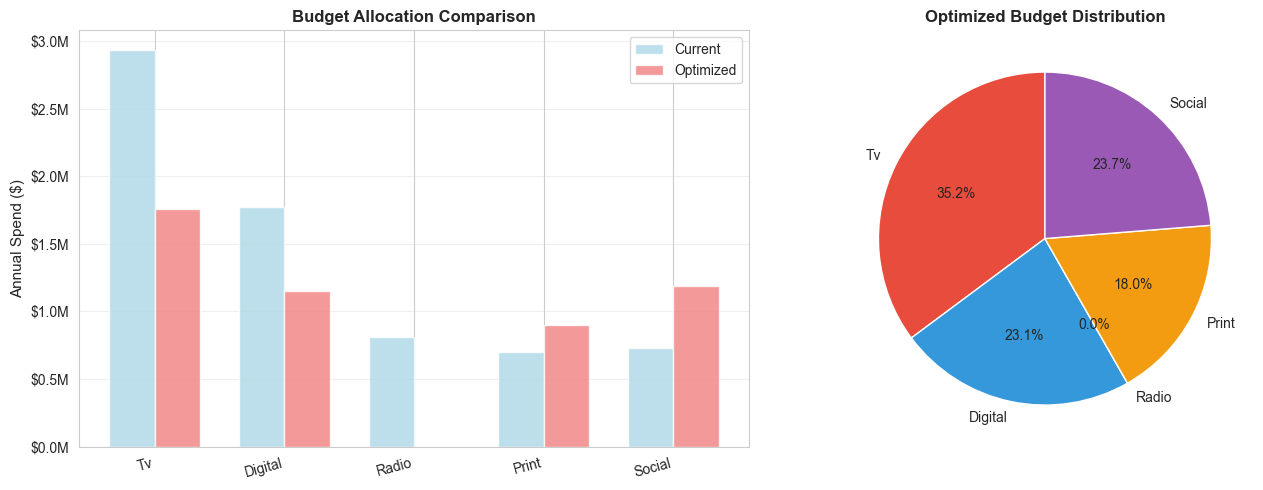


 Budget optimization exercise completed!


In [39]:
# Budget optimization exercise
print(" Budget Optimization Exercise\n")
print("="*70)

# Current allocation (from training data)
current_annual_spend = {}
for channel in marketing_channels:
    current_annual_spend[channel] = train_data[channel].sum()

total_current = sum(current_annual_spend.values())

print(" Current Annual Spend:")
print("-" * 70)
for channel, spend in sorted(current_annual_spend.items(), key=lambda x: -x[1]):
    pct = (spend / total_current) * 100
    print(f"{channel.replace('_spend', '').title():15} ${spend:>12,.0f}  ({pct:>5.1f}%)")
print("-" * 70)
print(f"{'TOTAL':15} ${total_current:>12,.0f}  (100.0%)")

# Get ROI analysis
roi_data = mmm_model.get_roi(train_data, train_data['sales'])

print("\n📈 Current ROI by Channel:")
print("-" * 70)
for _, row in roi_data.iterrows():
    print(f"{row['channel'].replace('_spend', '').title():15} ROI: {row['roi']:>6.2f}x")

# Simple optimization: Allocate based on ROI with constraints
print("\n Optimized Budget Allocation:")
print("-" * 70)
print("Strategy: Increase spend on high-ROI channels, decrease on low-ROI channels")
print("Constraint: Maintain at least 60% of current spend for brand channels (TV)\n")

# New budget: $5M
new_total_budget = 5_000_000

# Optimization logic
optimized_spend = {}
roi_dict = dict(zip(roi_data['channel'], roi_data['roi']))

# TV maintains 60% of current (brand presence)
tv_min = current_annual_spend['tv_spend'] * 0.6
remaining_budget = new_total_budget - tv_min

# Allocate remaining based on ROI
other_channels = [c for c in marketing_channels if c != 'tv_spend']
total_roi = sum([roi_dict[c] for c in other_channels])

optimized_spend['tv_spend'] = tv_min
for channel in other_channels:
    channel_roi = roi_dict[channel]
    allocation = remaining_budget * (channel_roi / total_roi)
    optimized_spend[channel] = allocation

print("\nOPTIMIZED ALLOCATION:")
print("-" * 70)
print(f"{'Channel':<15} {'Current':>15} {'Optimized':>15} {'Change':>15}")
print("-" * 70)

for channel in marketing_channels:
    current = current_annual_spend[channel]
    optimized = optimized_spend[channel]
    change = ((optimized - current) / current) * 100
    
    channel_name = channel.replace('_spend', '').title()
    print(f"{channel_name:<15} ${current:>14,.0f} ${optimized:>14,.0f} {change:>13.1f}%")

print("-" * 70)
print(f"{'TOTAL':<15} ${sum(current_annual_spend.values()):>14,.0f} ${new_total_budget:>14,.0f}")

# Estimate impact
print("\n Expected Impact:")
print("-" * 70)

# Rough estimate of sales lift
current_incremental = sum([roi_dict[ch] * current_annual_spend[ch] for ch in marketing_channels])
optimized_incremental = sum([roi_dict[ch] * optimized_spend[ch] for ch in marketing_channels])

lift = ((optimized_incremental - current_incremental) / current_incremental) * 100

print(f"Estimated sales lift: +{lift:.1f}%")
print(f"Additional revenue: ${optimized_incremental - current_incremental:,.0f}")
print("\n  Note: This is a simplified optimization. In practice, you should:")
print("   • Test changes incrementally")
print("   • Consider saturation effects at higher spend levels")
print("   • Account for competitive responses")
print("   • Monitor performance and adjust")

# Visualize the optimization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

channels_clean = [c.replace('_spend', '').title() for c in marketing_channels]
current_values = [current_annual_spend[c] for c in marketing_channels]
optimized_values = [optimized_spend[c] for c in marketing_channels]

x = np.arange(len(channels_clean))
width = 0.35

axes[0].bar(x - width/2, current_values, width, label='Current', color='lightblue', alpha=0.8)
axes[0].bar(x + width/2, optimized_values, width, label='Optimized', color='lightcoral', alpha=0.8)
axes[0].set_ylabel('Annual Spend ($)', fontsize=11)
axes[0].set_title('Budget Allocation Comparison', fontsize=12, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(channels_clean, rotation=15, ha='right')
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1e6:.1f}M'))

# Pie chart of optimized allocation
colors_pie = ['#e74c3c', '#3498db', '#2ecc71', '#f39c12', '#9b59b6']
axes[1].pie(optimized_values, labels=channels_clean, autopct='%1.1f%%', 
           startangle=90, colors=colors_pie)
axes[1].set_title('Optimized Budget Distribution', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n Budget optimization exercise completed!")

### 💼 Budget Optimization: Where MMM Delivers Real Value

This is where analytics meets business strategy. You're about to make a $5M decision!

#### **The Scenario:**

You're presenting to the CMO with these constraints:
- **Total Budget**: $5 million annually
- **Goal**: Maximize overall ROI
- **Constraint**: Can't kill brand channels (TV) - need minimum presence
- **Reality**: Channels interact, have saturation effects, and strategic value beyond pure ROI

#### **Why "Allocate to Highest ROI" Isn't Enough:**

**Problem 1: Saturation Effects**
- Digital has 2.5x ROI at current spend
- But if you 10x the spend, you'll saturate → ROI drops
- The model captures this with saturation curves

**Problem 2: Brand vs Performance**
- TV might have lower ROI but builds brand awareness
- This drives baseline sales that benefit all channels
- Can't measure everything in short-term ROI

**Problem 3: Strategic Considerations**
- Market positioning (need TV to look "legit")
- Competitive pressure (if you exit TV, competitor wins)
- Long-term customer value (some channels bring higher LTV)

**Problem 4: External Constraints**
- Existing contracts (can't cut channels mid-year)
- Seasonal requirements (need TV for holiday push)
- Organizational buy-in (stakeholders resist drastic changes)

#### **The Optimization Approach:**

**Step 1: Identify High-ROI Opportunities**
- Where can we increase spend profitably?
- Which channels have room before saturation?

**Step 2: Apply Business Constraints**
- Maintain minimum brand presence (60% of TV spend)
- Don't eliminate any channel entirely (diversification)
- Consider implementation feasibility

**Step 3: Allocate Remaining Budget Proportionally**
- Weight by ROI, but don't chase diminishing returns
- Balance across the funnel (awareness → conversion)

**Step 4: Estimate Impact**
- Use the MMM model to predict sales under new allocation
- Calculate expected lift
- Prepare for uncertainty (models aren't perfect!)

#### **What Success Looks Like:**

✅ **Good outcome**: 
- 10-20% improvement in overall ROI
- Maintains brand presence
- Implementable within 1-2 quarters

❌ **Bad outcome**:
- Chasing short-term ROI, sacrificing long-term brand
- Putting all eggs in one basket (over-concentration)
- Ignoring saturation (expecting linear scale)

#### **Real-World Caution:**

In practice, you'd:
1. Test changes gradually (shift 10-20%, not 100%)
2. Monitor actual vs predicted results
3. Adjust as you learn
4. Run incrementality tests to validate
5. Coordinate with creative and channel teams

Let's optimize the budget:

---

<a id='section7'></a>
## 7. Summary and Best Practices

### Key Takeaways

#### Marketing Mix Modeling (MMM)
- ✅ **Top-down approach** for understanding aggregate marketing effectiveness
- ✅ **Includes offline channels** (TV, Radio, Print) alongside digital
- ✅ **Captures carryover effects** through adstock transformation
- ✅ **Models diminishing returns** via saturation curves
- ✅ **Best for strategic planning** and long-term budget allocation
- ⚠️ Requires 2-3 years of data, updated quarterly/annually

#### Multi-Touch Attribution (MTA)
- ✅ **Bottom-up approach** analyzing individual customer journeys
- ✅ **Granular insights** into digital touchpoint effectiveness
- ✅ **Real-time optimization** capabilities
- ✅ **Multiple models available**: Last-touch, Linear, Time-decay, Position-based
- ✅ **Best for digital optimization** and tactical decisions
- ⚠️ Limited offline coverage, privacy challenges

#### When to Use Each
- **MMM**: Offline presence, strategic planning, privacy-first environment
- **MTA**: Digital-first business, real-time optimization, short sales cycles
- **Both**: Omnichannel strategy, comprehensive analytics capabilities

### Implementation Checklist

#### Before You Start:
- [ ] Define clear business objectives
- [ ] Assess data availability and quality
- [ ] Identify key marketing channels
- [ ] Determine success metrics (ROI, ROAS, etc.)
- [ ] Allocate resources (time, budget, team)

#### For MMM Implementation:
- [ ] Collect 2-3 years of weekly spend and sales data
- [ ] Include all relevant channels (online + offline)
- [ ] Gather external variables (seasonality, promotions, etc.)
- [ ] Choose appropriate transformations (adstock, saturation)
- [ ] Use regularization to prevent overfitting
- [ ] Validate with hold-out data
- [ ] Run incrementality tests to calibrate
- [ ] Update model quarterly or annually

#### For MTA Implementation:
- [ ] Implement comprehensive tracking across channels
- [ ] Resolve user identity (cross-device, cross-channel)
- [ ] Define attribution window (7, 14, 30 days)
- [ ] Choose attribution model(s) to use
- [ ] Compare multiple models for robustness
- [ ] Validate against incrementality tests
- [ ] Monitor and update regularly
- [ ] Ensure privacy compliance (GDPR, CCPA, etc.)

### Common Pitfalls to Avoid

1. **Over-reliance on one approach** - Consider using both MMM and MTA
2. **Ignoring data quality** - Garbage in, garbage out
3. **Not validating models** - Use incrementality tests
4. **Treating attribution as truth** - It's always an estimate
5. **Forgetting context** - External factors matter
6. **Static models** - Update regularly as market changes
7. **Complexity for its own sake** - Start simple, add complexity as needed

### The Future of Marketing Measurement

#### Emerging Trends:
- **Privacy-First Attribution** - Adapting to iOS 14+, cookie deprecation
- **Unified Measurement** - Combining MMM and MTA insights
- **Real-Time MMM** - More frequent model updates
- **Machine Learning** - Automated model selection and optimization
- **Incrementality-First** - More focus on causal inference
- **Multi-Touch MMM** - Incorporating journey-level data into MMM

### Resources for Further Learning

#### Books:
- *Marketing Analytics* by Winston & Goldsmith
- *Digital Marketing Analytics* by Hemann & Burbary
- *Causal Inference* by Pearl & Mackenzie

#### Tools & Frameworks:
- **Open Source:** PyMC-Marketing, Robyn (Meta), LightweightMMM (Google)
- **Commercial:** Google Analytics, Adobe Analytics, Neustar, Nielsen

#### Research:
- Google's Meridian MMM framework
- Meta's Robyn open-source MMM
- Academic papers on causal inference in marketing

---


You've completed the Marketing Mix Modeling and Multi-Touch Attribution hands-on lab!

You now understand:
- The challenges in marketing measurement
- How MMM provides top-down insights
- How MTA analyzes customer journeys
- When to use each approach
- Practical implementation considerations
- How to optimize marketing budgets

### Next Steps:
1. Apply these concepts to your own marketing data
2. Experiment with different model configurations
3. Validate findings with incrementality tests
4. Combine insights from multiple approaches
5. Share learnings with your organization

